In [114]:
import gc
import json
import os
import sys
from dataclasses import dataclass, field
from functools import partial
from typing import Dict, List, Optional

import datasets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn.functional as F
from einops import einsum
from matplotlib.gridspec import GridSpec
from safetensors.torch import load_file
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer

from sae.data import chunk_and_tokenize

sys.path.append("..")

%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [56]:
ckpt_path = "/home/sid/tensor-sae/checkpoints/pythia14m-all-layers-rp1t/pythia70m-all-layers-rp1t-sample_20240912_003009/layers.0_layers.1_layers.2_layers.3_layers.4_layers.5/sae-915.safetensors"
model_name = "EleutherAI/pythia-70m"

# ckpt_path = "/home/sid/tensor-sae/checkpoints/pythia14m-all-layers-rp1t/pythia14m-all-layers-rp1t-sample_20240907_194626/layers.0_layers.1_layers.2_layers.3_layers.4_layers.5/sae-915.safetensors"
# model_name = "EleutherAI/pythia-14m"

In [57]:
# to use jacrevd need eager implementation
model = AutoModelForCausalLM.from_pretrained(
    model_name, attn_implementation="eager"
).cuda()
tokenizer = AutoTokenizer.from_pretrained(model_name)

sae_ckpt = load_file(ckpt_path, device="cuda:0")

feature_encoder_weights = sae_ckpt.get("encoder.weight", sae_ckpt.get("weight"))
feature_encoder_bias = sae_ckpt.get("encoder.bias", sae_ckpt.get("bias"))
# legacy keys
feature_decoder_weights = sae_ckpt["decoder.weight"]
feature_decoder_bias = sae_ckpt["decoder.bias"]

In [58]:
def set_layer_weights(model, k, value=0.0):
    """
    Sets all weights in layer k and above to a specified value for the Pythia 70m model.

    Args:
    model (AutoModelForCausalLM): The Pythia 70m model
    k (int): The index of the first layer to modify
    value (float): The value to set the weights to (default is 0.0)
    """
    # Ensure k is valid
    num_layers = model.config.num_hidden_layers
    if k < 0 or k >= num_layers:
        raise ValueError(f"k must be between 0 and {num_layers-1}")

    # Set weights for transformer layers
    for i in range(k, num_layers):
        layer = model.gpt_neox.layers[i]
        for param in layer.parameters():
            param.data.fill_(value)

    # Set weights for the final layer norm
    if k == 0:
        for param in model.gpt_neox.final_layer_norm.parameters():
            param.data.fill_(value)

    # Set weights for the output layer (lm_head)
    model.embed_out.weight.data.fill_(value)

    print(
        f"Set weights to {value} for layers {k} to {num_layers-1}, final layer norm (if k=0), and lm_head"
    )

In [59]:
model

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (a

In [60]:
# set_layer_weights(model, 2, value=1)

In [61]:
seed = 42
seq_len = 64
GLOBAL_MAX_DS_SIZE = 1_000
dataset = datasets.load_dataset(
    "togethercomputer/RedPajama-Data-1T-Sample",
    split="train",
    trust_remote_code=True,
)

dataset = (
    dataset.train_test_split(test_size=0.8, seed=seed)
    .get("test")
    .select(range(GLOBAL_MAX_DS_SIZE))
)

tokenized = chunk_and_tokenize(dataset, tokenizer, max_seq_len=seq_len)

In [62]:
@dataclass
class InterventionOutputs:
    activation_positions: torch.Tensor
    clean_base_outputs: torch.Tensor
    intervened_later_outputs: torch.Tensor
    v_j: torch.Tensor
    v_k: torch.Tensor
    is_valid: torch.Tensor

In [63]:
@dataclass
class FeatureStats:
    causality: List[float] = field(default_factory=list)
    cosine: List[float] = field(default_factory=list)
    error: List[float] = field(default_factory=list)
    feature_activation_strength: List[float] = field(default_factory=list)


@dataclass
class GlobalFeatureStatistics:
    feature_activation_rate: torch.Tensor
    acc_features: torch.Tensor
    total_active_features: float
    avg_active_features_per_token: float
    feature_dict: Dict[int, FeatureStats]


def compute_feature_statistics(
    model,
    tokenized,
    feature_encoder_weights,
    feature_encoder_bias,
    sae_top_k: int = 128,
    batch_size: int = 256,
    exclude_first_k_tokens: int = 4,
):
    # (N,)
    global_feature_activation_frequencies = torch.zeros(
        feature_encoder_weights.shape[0], device=model.device
    )
    # TODO also accumulate feature activations for global strength statistic
    global_acc_feature_activations = torch.zeros(
        feature_encoder_weights.shape[0], device=model.device
    )

    dataloader = torch.utils.data.DataLoader(
        tokenized, batch_size=batch_size, shuffle=False
    )

    for batch in tqdm(dataloader, desc="Processing batches"):
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = torch.ones_like(input_ids, device=model.device)

        with torch.no_grad():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_hidden_states=True,
            )
            hiddens = outputs.hidden_states

        stacked_hiddens = torch.cat(hiddens[1:], dim=-1)[:, exclude_first_k_tokens:, :]

        encoded_features = torch.einsum(
            "be,nse->nsb", feature_encoder_weights, stacked_hiddens
        )
        encoded_features = encoded_features + feature_encoder_bias.unsqueeze(
            0
        ).unsqueeze(0)

        k_th_strongest = (
            torch.topk(encoded_features, k=sae_top_k, dim=-1)
            .values[:, :, -1]
            .unsqueeze(-1)
        )

        batch_binary_mask = (encoded_features >= k_th_strongest).float()

        global_feature_activation_frequencies += batch_binary_mask.sum(dim=(0, 1))
        # Normalize to prevent overflow
        global_acc_feature_activations += (encoded_features * batch_binary_mask).sum(
            dim=(0, 1)
        )

    seq_len = tokenized[0]["input_ids"].shape[0] - exclude_first_k_tokens
    feature_activation_rate = global_feature_activation_frequencies / (
        len(tokenized) * seq_len
    )
    normalized_acc_features = global_acc_feature_activations / (
        len(tokenized) * seq_len
    )

    total_active = global_feature_activation_frequencies.sum().item()
    avg_active_per_token = total_active / (len(tokenized) * seq_len)

    feature_dict = {i: FeatureStats() for i in range(feature_encoder_weights.shape[-1])}

    return GlobalFeatureStatistics(
        feature_activation_rate=feature_activation_rate,
        acc_features=normalized_acc_features,
        total_active_features=total_active,
        avg_active_features_per_token=avg_active_per_token,
        feature_dict=feature_dict,
    )

In [64]:
def perform_intervention(
    model: torch.nn.Module,
    batch: torch.Tensor,
    global_feature_activation_rate: Optional[torch.Tensor],
    global_acc_feature_activations: Optional[torch.Tensor],
    intervention_index: int,
    readout_index: int,
    feature_encoder_weights: torch.Tensor,
    feature_encoder_bias: torch.Tensor,
    feature_decoder_weights: torch.Tensor,
    lambda_value: float = 1.0,
    num_tokens: int = 1,
    feature_top_k: int = 1,
    exclude_first_k_tokens: int = 0,
    sae_top_k: int = 128,
) -> InterventionOutputs:
    """
    Perform an intervention on a model's activations using Sparse Autoencoder (SAE) features.

    Args:
        model: The PyTorch model to intervene on.
        batch: Input tensor to the model.
        global_feature_activation_rate: the global feature activation rate statistic
        global_acc_feature_activations: the global accumulated feature activations statistic
        intervention_index: Index of the layer to intervene on.
        readout_index: Index of the layer to read out from.
        feature_encoder_weights: Weights of the SAE encoder.
        feature_encoder_bias: Bias of the SAE encoder.
        feature_decoder_weights: Weights of the SAE decoder.
        lambda_value: Strength of the intervention (default: 1.0).
        num_tokens: Number of tokens to intervene on (default: 1).
        feature_top_k: Index of the specific feature to intervene on.
        exclude_first_k_tokens: Number of tokens to exclude from the beginning (default: 0).

    Returns:
        the results of the intervention as an InterventionOutputs object
    """

    activation_positions = None
    clean_base_outputs = None
    intervened_late_outputs = None
    # j < k in layer idx
    v_j = None
    v_k = None
    is_valid = None

    num_tokens = min(
        num_tokens, max(1, batch["input_ids"].shape[0] - exclude_first_k_tokens)
    )

    # Compute top-k index based on global activation rates
    # (or accumulated activation for each feature)
    _, top_k_feature_index = torch.kthvalue(
        global_feature_activation_rate
        if global_acc_feature_activations is None
        else global_acc_feature_activations,
        k=feature_top_k,
        dim=-1,
    )

    def strengthen_specific_features(module, input, output, layer_offset=0):
        nonlocal \
            activation_positions, \
            clean_base_outputs, \
            intervened_late_outputs, \
            v_j, \
            v_k, \
            is_valid

        embed_dim = output[0].shape[-1]
        feature_encoder_segment = feature_encoder_weights[
            :,
            (intervention_index - layer_offset) * embed_dim : (
                intervention_index - layer_offset + 1
            )
            * embed_dim,
        ]
        feature_decoder_segment = feature_decoder_weights[
            :,
            (intervention_index - layer_offset) * embed_dim : (
                intervention_index - layer_offset + 1
            )
            * embed_dim,
        ]

        batch_size, seq_len, _ = output[0].shape
        clean_base_outputs = output[0]

        # Encode input activations after excluding first k tokens
        feature_activation = (
            einsum(
                output[0][:, exclude_first_k_tokens:],
                feature_encoder_segment.T,
                "b s e, e n -> b s n",
            )
            - feature_encoder_bias
        )
        sae_top_k_mask = torch.zeros(
            batch_size,
            feature_activation.shape[1],
            feature_encoder_segment.shape[0],
            device=output[0].device,
        ).bool()
        _, top_k_indices = torch.topk(feature_activation, k=sae_top_k, dim=-1)
        sae_top_k_mask.scatter_(2, top_k_indices, 1)

        # Get the decoder vectors for the specified feature index
        v_j = feature_decoder_segment[None, top_k_feature_index, :]

        # Select the tokens where the feature is active
        token_mask = (
            feature_activation[:, :, top_k_feature_index]
            > 0 & sae_top_k_mask[:, :, top_k_feature_index]
        )
        activation_positions = token_mask.nonzero()
        activation_positions[:, 1] += output[0].shape[1] - token_mask.shape[1]

        new_output = output[0].clone()
        intervened_late_outputs = new_output
        # Add intervention lambda * v_j to selected token positions after exclusion
        new_output[:, exclude_first_k_tokens:] += lambda_value * torch.einsum(
            "be,bs->bse", v_j, token_mask
        )
        new_outputs = [new_output] + list(output[1:])

        # Assign v_k
        intervention_decoder_segment = feature_decoder_weights[
            :,
            (readout_index - layer_offset) * embed_dim : (
                readout_index - layer_offset + 1
            )
            * embed_dim,
        ]
        v_k = intervention_decoder_segment[None, top_k_feature_index, :]

        # Check if the feature fires in any of the tokens after exclusion
        is_valid = token_mask.bool()

        return tuple(new_outputs)

    if "gpt" in model_name:
        intervention_hook = model.transformer.h[
            intervention_index
        ].register_forward_hook(
            partial(strengthen_specific_features, layer_offset=intervention_index)
        )
    else:
        intervention_hook = model.gpt_neox.layers[
            intervention_index
        ].register_forward_hook(
            partial(strengthen_specific_features, layer_offset=intervention_index)
        )

    with intervention_hook, torch.no_grad():
        model(**batch)

    return InterventionOutputs(
        activation_positions,
        clean_base_outputs,
        intervened_late_outputs,
        v_j,
        v_k,
        is_valid,
    )

In [65]:
# Usage
stats = compute_feature_statistics(
    model,
    tokenized,
    feature_encoder_weights,
    feature_encoder_bias,
    sae_top_k=128,
    batch_size=512,
)

print(f"Total number of active features: {stats.total_active_features}")
print(
    f"Average number of active features per token: {stats.avg_active_features_per_token:.2f}"
)

Processing batches:   0%|          | 0/39 [00:00<?, ?it/s]

Processing batches: 100%|██████████| 39/39 [00:19<00:00,  2.04it/s]

Total number of active features: 149952160.0
Average number of active features per token: 128.00


In [66]:
intervention_index = 2
readout_index = 3
lambda_value = 1.0
num_tokens = 1
exclude_first_k_tokens = 1
sae_top_k = 128

# Create a small test batch
text = ["Hello, world!", "Hello, world!"]
test_batch = tokenizer(text, return_tensors="pt").to("cuda")

feature_top_k = torch.arange(1, 20, device="cuda")
res = []

for k in feature_top_k:
    # Run the intervention
    results = perform_intervention(
        model=model,
        batch=test_batch,
        global_feature_activation_rate=stats.feature_activation_rate,
        global_acc_feature_activations=stats.acc_features,
        intervention_index=intervention_index,
        readout_index=readout_index,
        feature_encoder_weights=feature_encoder_weights,
        feature_encoder_bias=feature_encoder_bias,
        feature_decoder_weights=feature_decoder_weights,
        lambda_value=lambda_value,
        num_tokens=num_tokens,
        feature_top_k=k.item(),
        exclude_first_k_tokens=exclude_first_k_tokens,
        sae_top_k=sae_top_k,
    )
    res.append(results)

In [67]:
results.is_valid

tensor([[True, True, True],
        [True, True, True]], device='cuda:0')

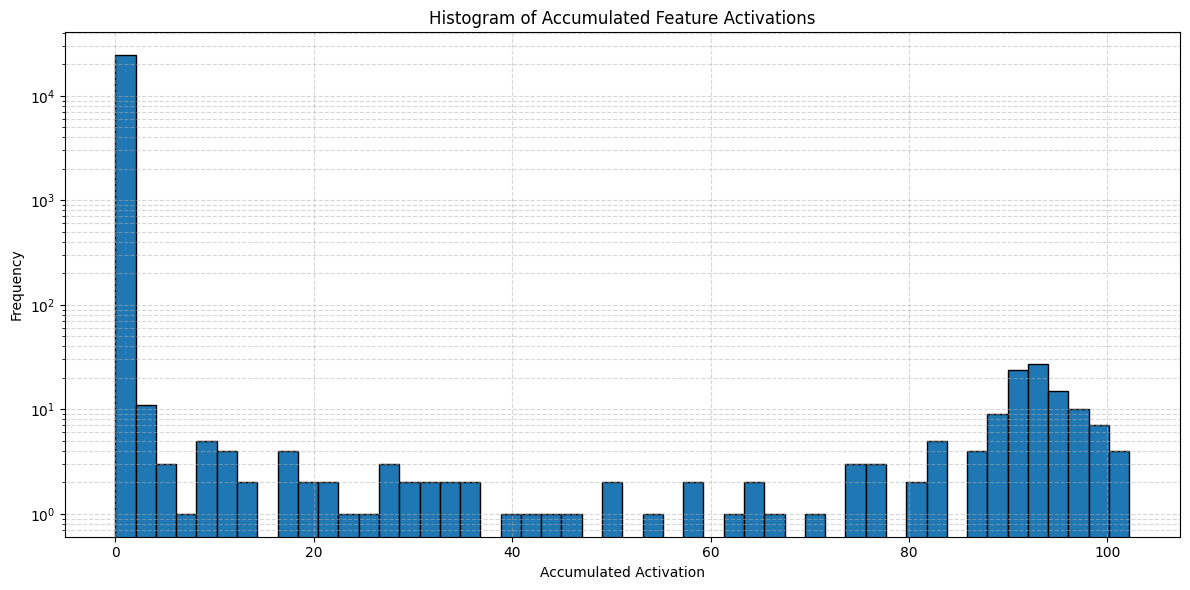

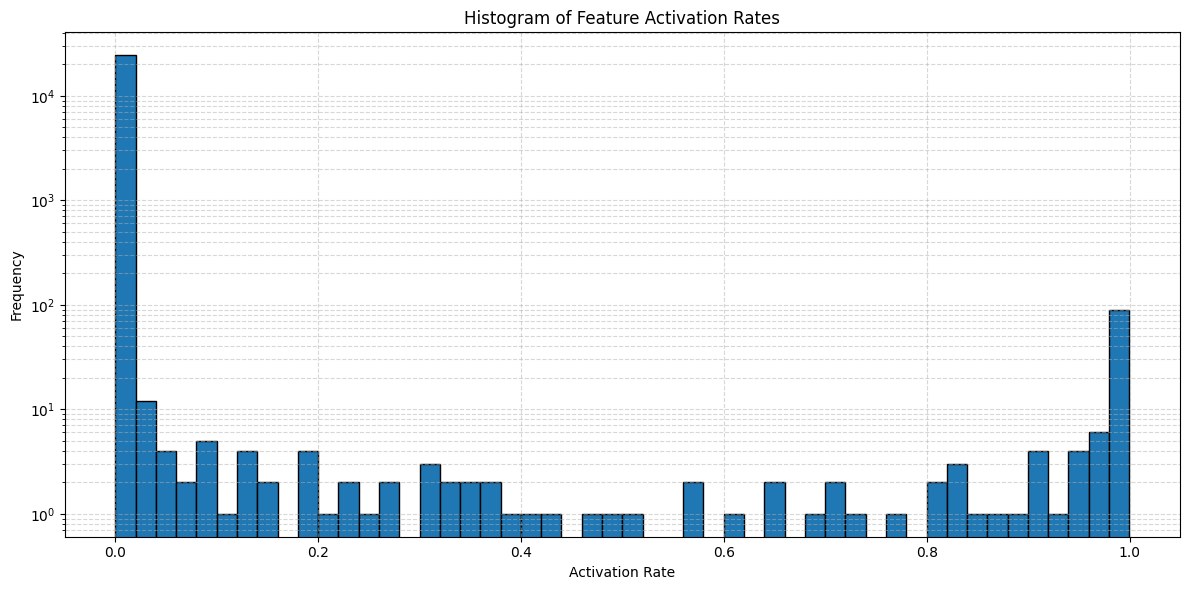

Min accumulated activation: 0.0000
Max accumulated activation: 102.2074
Mean accumulated activation: 0.4858
Median accumulated activation: 0.0000
Min activation rate: 0.0000
Max activation rate: 0.9995
Mean activation rate: 0.0052
Median activation rate: 0.0000


In [68]:
import matplotlib.pyplot as plt

# Create a histogram of accumulated feature activations
plt.figure(figsize=(12, 6))
plt.hist(stats.acc_features.cpu().numpy(), bins=50, edgecolor='black')
plt.title('Histogram of Accumulated Feature Activations')
plt.xlabel('Accumulated Activation')
plt.ylabel('Frequency')
plt.yscale('log')  # Use log scale for y-axis to better visualize the distribution
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Create a histogram of feature activation rates
plt.figure(figsize=(12, 6))
plt.hist(stats.feature_activation_rate.cpu().numpy(), bins=50, edgecolor='black')
plt.title('Histogram of Feature Activation Rates')
plt.xlabel('Activation Rate')
plt.ylabel('Frequency')
plt.yscale('log')  # Use log scale for y-axis to better visualize the distribution
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Print some statistics about the accumulated feature activations
print(f"Min accumulated activation: {stats.acc_features.min().item():.4f}")
print(f"Max accumulated activation: {stats.acc_features.max().item():.4f}")
print(f"Mean accumulated activation: {stats.acc_features.mean().item():.4f}")
print(f"Median accumulated activation: {stats.acc_features.median().item():.4f}")

# Print some statistics about the feature activation rates
print(f"Min activation rate: {stats.feature_activation_rate.min().item():.4f}")
print(f"Max activation rate: {stats.feature_activation_rate.max().item():.4f}")
print(f"Mean activation rate: {stats.feature_activation_rate.mean().item():.4f}")
print(f"Median activation rate: {stats.feature_activation_rate.median().item():.4f}")


In [69]:
model.config

GPTNeoXConfig {
  "_name_or_path": "EleutherAI/pythia-70m",
  "architectures": [
    "GPTNeoXForCausalLM"
  ],
  "attention_bias": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.1,
  "eos_token_id": 0,
  "hidden_act": "gelu",
  "hidden_dropout": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 2048,
  "model_type": "gpt_neox",
  "num_attention_heads": 8,
  "num_hidden_layers": 6,
  "rope_scaling": null,
  "rotary_emb_base": 10000,
  "rotary_pct": 0.25,
  "tie_word_embeddings": false,
  "torch_dtype": "float16",
  "transformers_version": "4.43.3",
  "use_cache": true,
  "use_parallel_residual": true,
  "vocab_size": 50304
}

In [70]:
def plot_feature_cosine_similarity(stats, feature_decoder_weights, model, k):
    # Select a top feature
    top_feature_index = torch.kthvalue(stats.feature_activation_rate, k=k, dim=0)[1]
    dec_feat_vectors = feature_decoder_weights[top_feature_index].reshape(
        model.config.num_hidden_layers, model.config.hidden_size
    )

    # Compute cosine similarity between layers
    num_layers = model.config.num_hidden_layers
    cos_sim = torch.nn.functional.cosine_similarity(
        dec_feat_vectors.unsqueeze(1),  # Shape: [num_layers, 1, hidden_size]
        dec_feat_vectors.unsqueeze(0),  # Shape: [1, num_layers, hidden_size]
        dim=2  # Compute similarity along the hidden_size dimension
    )
    # cos_sim shape: [num_layers, num_layers]

    # Create a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cos_sim.cpu().numpy(), cmap="coolwarm", vmin=-1, vmax=1, center=0)
    plt.title(f"Cosine Similarity of Decoder Vectors (Top {k} Feature)")
    plt.xlabel("Vector Index")
    plt.ylabel("Vector Index")
    plt.tight_layout()
    plt.show()

    # Print some statistics about the cosine similarities
    print(f"Min cosine similarity: {cos_sim.min().item():.4f}")
    print(f"Max cosine similarity: {cos_sim.max().item():.4f}")
    print(f"Mean cosine similarity: {cos_sim.mean().item():.4f}")
    print(f"Median cosine similarity: {cos_sim.median().item():.4f}")

# Example usage:
# plot_feature_cosine_similarity(stats, feature_decoder_weights, model, k=1)


In [71]:
# Example usage with specific feature indices
intervention_index = 4
readout_index = 5
text = ["Hello, world!", "Hello, world!"]
test_batch = tokenizer(text, return_tensors="pt").to("cuda")

rank_k_feature = 2
sae_top_k = 128

intervention = perform_intervention(
    model=model,
    batch=test_batch,
    global_feature_activation_rate=stats.feature_activation_rate,
    global_acc_feature_activations=stats.acc_features,
    intervention_index=intervention_index,
    readout_index=readout_index,
    feature_encoder_weights=feature_encoder_weights,
    feature_encoder_bias=feature_encoder_bias,
    feature_decoder_weights=feature_decoder_weights,
    lambda_value=1.0,
    num_tokens=1,
    feature_top_k=rank_k_feature,
    exclude_first_k_tokens=1,
    sae_top_k=sae_top_k,
)

In [72]:
intervention.activation_positions

tensor([[0, 2],
        [1, 2]], device='cuda:0')

### Causal Attribution


In [73]:
from torch.func import functional_call, jacrev, vmap


def compute_jacobian(model, j_activations, pos, j, k, sum_over_tokens: bool = True):
    """
    Compute batched Jacobians of layer k's activations w.r.t. layer j's activations for select tokens.

    Args:
    - model: The language model (GPT2Model or similar)
    - j_activations: Activations of layer j (shape: [batch_size, seq_len, hidden_size])
    - pos: Token positions (shape: [batch_size, num_selected_tokens])
    - j: Index of the input layer
    - k: Index of the output layer

    Returns:
    - Batch of Jacobians
    """
    j_activations.requires_grad_(True)

    def forward_to_k(x):
        activations = x.unsqueeze(1)
        for layer_idx in range(j, k + 1):
            layer, params = get_layer_and_params(model, layer_idx)
            activations = functional_call(layer, params, activations)[0]
        return activations

    def get_layer_and_params(model, layer_idx):
        if "gpt2" in model.__class__.__name__.lower():
            layer = model.transformer.h[layer_idx]
        else:
            layer = model.gpt_neox.layers[layer_idx]
        return layer, dict(layer.named_parameters())

    # Create a mask for the selected positions
    batch_size, seq_len = j_activations.shape[:2]
    mask = torch.zeros(
        (batch_size, seq_len), device=j_activations.device, dtype=torch.bool
    )
    mask[pos[:, 0], pos[:, 1]] = True

    # Select activations for specified positions
    selected_activations = j_activations * mask.unsqueeze(-1)

    # Sum the selected activations for each batch
    if sum_over_tokens:
        selected_activations = selected_activations.sum(dim=1, keepdim=True)

    # Compute Jacobian
    jacobian = vmap(jacrev(forward_to_k))(selected_activations)

    return jacobian.squeeze()

Sanity check to make sure Jacobian is correct


In [74]:
# Collect activations from GPT2
sample = tokenized[0:2]["input_ids"]

j, k = 1, 2
lam = 1e-2

# Perform intervention
intervention = perform_intervention(
    model=model,
    batch={
        "input_ids": sample.cuda(),
        "attention_mask": torch.ones_like(sample, device="cuda:0"),
    },
    global_feature_activation_rate=stats.feature_activation_rate,
    global_acc_feature_activations=stats.acc_features,
    intervention_index=j,
    readout_index=k,
    feature_encoder_weights=feature_encoder_weights,
    feature_encoder_bias=feature_encoder_bias,
    feature_decoder_weights=feature_decoder_weights,
    lambda_value=lam,
    num_tokens=1,
    feature_top_k=1,
    exclude_first_k_tokens=0,
    sae_top_k=128,
)

# Perform clean run (no intervention)
clean_intervention = perform_intervention(
    model=model,
    batch={
        "input_ids": sample.cuda(),
        "attention_mask": torch.ones_like(sample, device="cuda:0"),
    },
    global_feature_activation_rate=stats.feature_activation_rate,
    global_acc_feature_activations=stats.acc_features,
    intervention_index=j,
    readout_index=k,
    feature_encoder_weights=feature_encoder_weights,
    feature_encoder_bias=feature_encoder_bias,
    feature_decoder_weights=feature_decoder_weights,
    lambda_value=0,
    num_tokens=1,
    feature_top_k=1,
    exclude_first_k_tokens=0,
)

# Compute Jacobian
jacobian = compute_jacobian(
    model, intervention.clean_base_outputs, intervention.activation_positions, j, k
)

# Check consequent_embeddings ~= original_embeddings_at_the_higher_layer + jacobian @ v_j * lam
with torch.no_grad():
    jacobian_approx = clean_intervention.intervened_later_outputs.clone()

    # Create a mask for the selected token positions
    batch_size, seq_len, _ = jacobian_approx.shape
    token_mask = torch.zeros(
        batch_size, seq_len, device=jacobian_approx.device, dtype=torch.bool
    )
    token_mask[
        intervention.activation_positions[:, 0], intervention.activation_positions[:, 1]
    ] = True

    # Apply lam * JVP only at the correct activation positions
    jvp = lam * torch.einsum("j,bij->bi", intervention.v_j.squeeze(), jacobian)
    jacobian_approx += jvp.unsqueeze(1) * token_mask.unsqueeze(-1)

error = torch.mean((intervention.intervened_later_outputs - jacobian_approx) ** 2)

print(f"error: {error}")

error: 9.835975089966809e-11


In [75]:
@torch.no_grad()
def compute_causal_attribution_strength(
    j: int,
    k: int,
    model: torch.nn.Module,
    inputs: Dict[str, torch.Tensor],
    feature_encoder_weights: torch.Tensor,
    feature_encoder_bias: torch.Tensor,
    feature_decoder_weights: torch.Tensor,
    global_feature_activation_rate: torch.Tensor,
    global_acc_feature_activations: torch.Tensor,
    lambda_value: float = 1.0,
    rank_k_feature: int = 1,
    num_tokens: int = 1,
    exclude_first_k_tokens: int = 0,
    sae_top_k: int = 128,
    fold_in_dec_bias: bool = False,
):
    def perform_intervention_and_compute_jacobian():
        intervention = perform_intervention(
            model=model,
            batch=inputs,
            global_feature_activation_rate=global_feature_activation_rate,
            global_acc_feature_activations=global_acc_feature_activations,
            intervention_index=j,
            readout_index=k,
            feature_encoder_weights=feature_encoder_weights,
            feature_encoder_bias=feature_encoder_bias,
            feature_decoder_weights=feature_decoder_weights,
            lambda_value=lambda_value,
            num_tokens=num_tokens,
            feature_top_k=rank_k_feature,
            exclude_first_k_tokens=exclude_first_k_tokens,
            sae_top_k=sae_top_k,
        )

        jacobian = compute_jacobian(
            model,
            intervention.clean_base_outputs,
            intervention.activation_positions,
            j,
            k,
        )

        return intervention, jacobian

    def compute_metrics(intervention, jacobian):
        v_k_norm_squared = torch.norm(intervention.v_k, p=2, dim=-1).pow(2)

        proportion_explained = (
            torch.einsum(
                "bie,be,bi->b",
                jacobian,
                intervention.v_j.squeeze(1),
                intervention.v_k.squeeze(1),
            )
            / v_k_norm_squared
        )

        pred = torch.einsum("bie,be->bi", jacobian, intervention.v_j.squeeze(1))
        causal_cosine = F.cosine_similarity(pred, intervention.v_k.squeeze(1), dim=-1)

        error = torch.mean((pred - intervention.v_k.squeeze(1)) ** 2, dim=-1)
        relative_error = error / v_k_norm_squared

        return proportion_explained, causal_cosine, error, relative_error

    intervention, jacobian = perform_intervention_and_compute_jacobian()
    metrics = compute_metrics(intervention, jacobian)

    return (
        *metrics,
        jacobian,
        intervention.v_j,
        intervention.v_k,
        intervention.is_valid,
    )


def plot_histograms(data, params):
    num_plots = len(data)
    num_cols = 2
    num_rows = (num_plots + 1) // 2
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10 * num_rows))
    fig.suptitle("Distribution of Metrics", fontsize=16)

    metrics = list(data.keys())
    titles = [
        "Causality Distribution",
        "Causal Cosine Distribution",
        "Error Distribution",
        "Relative Error Distribution",
    ]
    xlabels = ["Causality", "Causal Cosine", "Error", "Relative Error"]

    for idx, (metric, title, xlabel) in enumerate(zip(metrics, titles, xlabels)):
        ax = axs[idx // num_cols, idx % num_cols] if num_rows > 1 else axs[idx]
        for param, values in data[metric].items():
            ax.hist(values, bins=50, alpha=0.5, label=f"{param}")
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Frequency")
        ax.legend(loc="upper right", fontsize="small")  # Place legend inside the plot
        ax.grid(True)
        if metric == "causality":
            ax.set_xlim(0, 2)

    plt.tight_layout()
    plt.show()


def process_batch(
    batch,
    model,
    i,
    j,
    feature_encoder_weights,
    feature_encoder_bias,
    feature_decoder_weights,
    lambda_value,
    feature_top_k,
    num_tokens,
    exclude_first_k_tokens,
):
    inputs = {"input_ids": batch["input_ids"].cuda()}
    return compute_causal_attribution_strength(
        j=i,
        k=j,
        model=model,
        inputs=inputs,
        feature_encoder_weights=feature_encoder_weights,
        feature_encoder_bias=feature_encoder_bias,
        feature_decoder_weights=feature_decoder_weights,
        global_feature_activation_rate=stats.feature_activation_rate,
        global_acc_feature_activations=stats.acc_features,
        lambda_value=lambda_value,
        rank_k_feature=feature_top_k,
        num_tokens=num_tokens,
        exclude_first_k_tokens=exclude_first_k_tokens,
    )


def process_dataset(model, dataset, batch_size, **kwargs):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    metrics = {
        "causality": [],
        "causal_cosines": [],
        "errors": [],
        "relative_errors": [],
    }

    for batch in tqdm(dataloader, desc="Processing batches"):
        results = process_batch(batch, model, **kwargs)
        causality, causal_cosine, error, relative_error, _, _, _, is_valid = results

        for metric, value in zip(
            metrics.keys(), [causality, causal_cosine, error, relative_error]
        ):
            metrics[metric].extend(value[is_valid].cpu().numpy())

    return {k: np.array(v) for k, v in metrics.items()}


def run_evaluation(
    params,
    model,
    dataset,
    batch_size,
    feature_encoder_weights,
    feature_encoder_bias,
    feature_decoder_weights,
    exclude_first_k_tokens,
):
    results = {
        metric: {}
        for metric in ["causality", "causal_cosines", "errors", "relative_errors"]
    }

    for i in params["i"]:
        for j in params["j"]:
            if i >= j:
                continue  # Skip invalid layer combinations
            for lambda_value in params["lambda_value"]:
                for feature_top_k in params["feature_select_k"]:
                    for num_tokens in params["num_tokens"]:
                        key = f"i={i}, j={j}, λ={lambda_value}, k={feature_top_k}, tokens={num_tokens}"
                        batch_results = process_dataset(
                            model=model,
                            dataset=dataset,
                            batch_size=batch_size,
                            i=i,
                            j=j,
                            feature_encoder_weights=feature_encoder_weights,
                            feature_encoder_bias=feature_encoder_bias,
                            feature_decoder_weights=feature_decoder_weights,
                            lambda_value=lambda_value,
                            feature_top_k=feature_top_k,
                            num_tokens=num_tokens,
                            exclude_first_k_tokens=exclude_first_k_tokens,
                        )
                        for metric in results:
                            results[metric][key] = batch_results[metric]

    plot_histograms(results, params)
    return results

In [76]:
# Example usage:
params = {
    "i": [0, 1, 2],  # Layer indices for intervention
    "j": [1, 2, 3],  # Layer indices for readout
    "lambda_value": [1.0],
    "feature_select_k": [1],
    "num_tokens": [1],
    "feature_select_percentile": [None],
}

# Clear GPU memory and garbage collect
torch.cuda.empty_cache()
gc.collect()

# Assuming 'tokenized' is your dataset and other variables are defined
sample_size = 10000
batch_size = 128
exclude_first_k_tokens = 2

# Select a subset of the dataset
sample_dataset = tokenized.select(range(sample_size))
if False:
    # Run the evaluation
    results = run_evaluation(
        params=params,
        model=model,
        dataset=sample_dataset,
        batch_size=batch_size,
        feature_encoder_weights=feature_encoder_weights,
        feature_encoder_bias=feature_encoder_bias,
        feature_decoder_weights=feature_decoder_weights,
        exclude_first_k_tokens=exclude_first_k_tokens,
    )

# Optional: Save results
# import pickle

# with open('evaluation_results.pkl', 'wb') as f:
#     pickle.dump(results, f)

print("Evaluation completed and results saved.")

# # Optional: Analyze results
# for metric, data in results.items():
#     print(f"\nAnalysis for {metric}:")
#     for key, values in data.items():
#         print(f"  {key}:")
#         print(f"    Mean: {np.mean(values):.4f}")
#         print(f"    Std: {np.std(values):.4f}")
#         print(f"    Min: {np.min(values):.4f}")
#         print(f"    Max: {np.max(values):.4f}")

Evaluation completed and results saved.


Encoder:
Layer 0: 21074 features
Layer 1: 1468 features
Layer 2: 538 features
Layer 3: 131 features
Layer 4: 1263 features
Layer 5: 102 features

Decoder:
Layer 0: 5031 features
Layer 1: 1828 features
Layer 2: 1100 features
Layer 3: 506 features
Layer 4: 3135 features
Layer 5: 12976 features


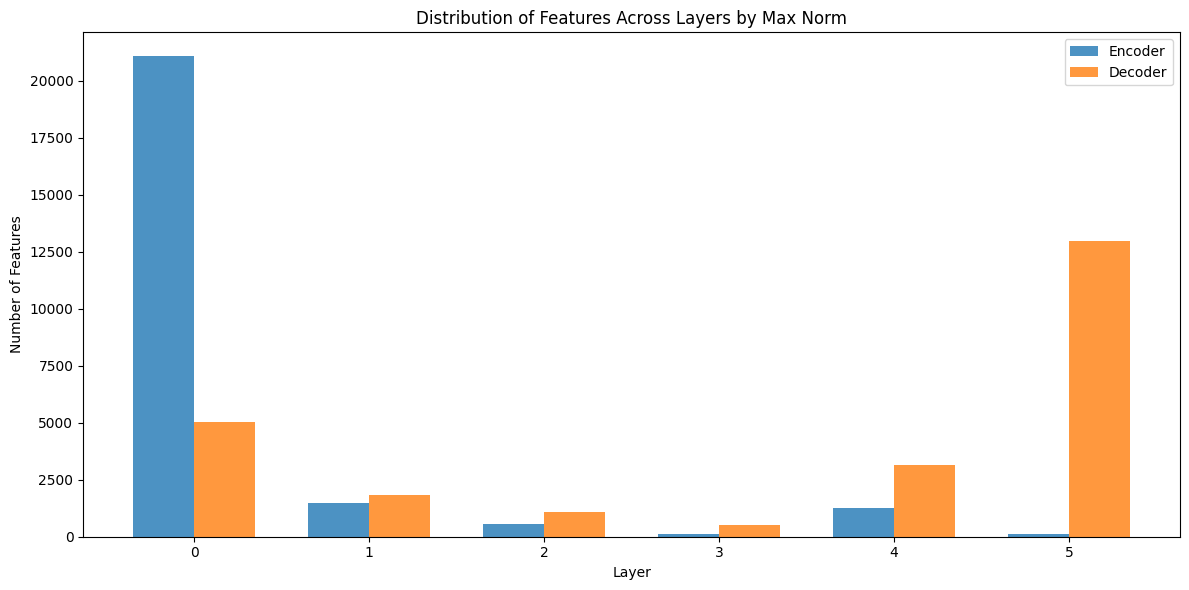

In [77]:
def bin_features_by_layer(feature_encoder_weights, feature_decoder_weights, num_layers):
    def calculate_layer_norms(weights, num_layers):
        """Calculate norms for each layer of the given weights."""
        layer_size = weights.shape[1] // num_layers
        layer_weights = torch.split(weights, layer_size, dim=1)
        return torch.stack([layer.norm(dim=1) for layer in layer_weights])

    """Bin features by their max norm layer for both encoder and decoder."""
    enc_norms = calculate_layer_norms(feature_encoder_weights, num_layers)
    dec_norms = calculate_layer_norms(feature_decoder_weights, num_layers)

    enc_max_norm_layers = enc_norms.argmax(dim=0)
    dec_max_norm_layers = dec_norms.argmax(dim=0)

    enc_layer_features = [[] for _ in range(num_layers)]
    dec_layer_features = [[] for _ in range(num_layers)]

    for feature_idx, (enc_layer_idx, dec_layer_idx) in enumerate(
        zip(enc_max_norm_layers, dec_max_norm_layers)
    ):
        enc_layer_features[enc_layer_idx.item()].append(feature_idx)
        dec_layer_features[dec_layer_idx.item()].append(feature_idx)

    enc_layer_features = [
        torch.tensor(features, device=feature_encoder_weights.device)
        for features in enc_layer_features
    ]
    dec_layer_features = [
        torch.tensor(features, device=feature_decoder_weights.device)
        for features in dec_layer_features
    ]

    return enc_layer_features, dec_layer_features


def print_feature_distribution(enc_binned_features, dec_binned_features):
    """Print summary of feature distribution across layers."""
    print("Encoder:")
    for layer, features in enumerate(enc_binned_features):
        print(f"Layer {layer}: {len(features)} features")

    print("\nDecoder:")
    for layer, features in enumerate(dec_binned_features):
        print(f"Layer {layer}: {len(features)} features")


def plot_feature_distribution(enc_binned_features, dec_binned_features, num_layers):
    """Visualize the distribution of features across layers."""
    enc_feature_counts = [len(features) for features in enc_binned_features]
    dec_feature_counts = [len(features) for features in dec_binned_features]

    plt.figure(figsize=(12, 6))
    x = range(num_layers)
    width = 0.35

    plt.bar(
        [i - width / 2 for i in x],
        enc_feature_counts,
        width,
        label="Encoder",
        alpha=0.8,
    )
    plt.bar(
        [i + width / 2 for i in x],
        dec_feature_counts,
        width,
        label="Decoder",
        alpha=0.8,
    )

    plt.title("Distribution of Features Across Layers by Max Norm")
    plt.xlabel("Layer")
    plt.ylabel("Number of Features")
    plt.legend()

    plt.xticks(x)
    plt.tight_layout()
    plt.show()


# Usage example:
num_layers = 6  # Adjust this based on your model's architecture
enc_binned_features, dec_binned_features = bin_features_by_layer(
    feature_encoder_weights, feature_decoder_weights, num_layers
)

print_feature_distribution(enc_binned_features, dec_binned_features)
plot_feature_distribution(enc_binned_features, dec_binned_features, num_layers)

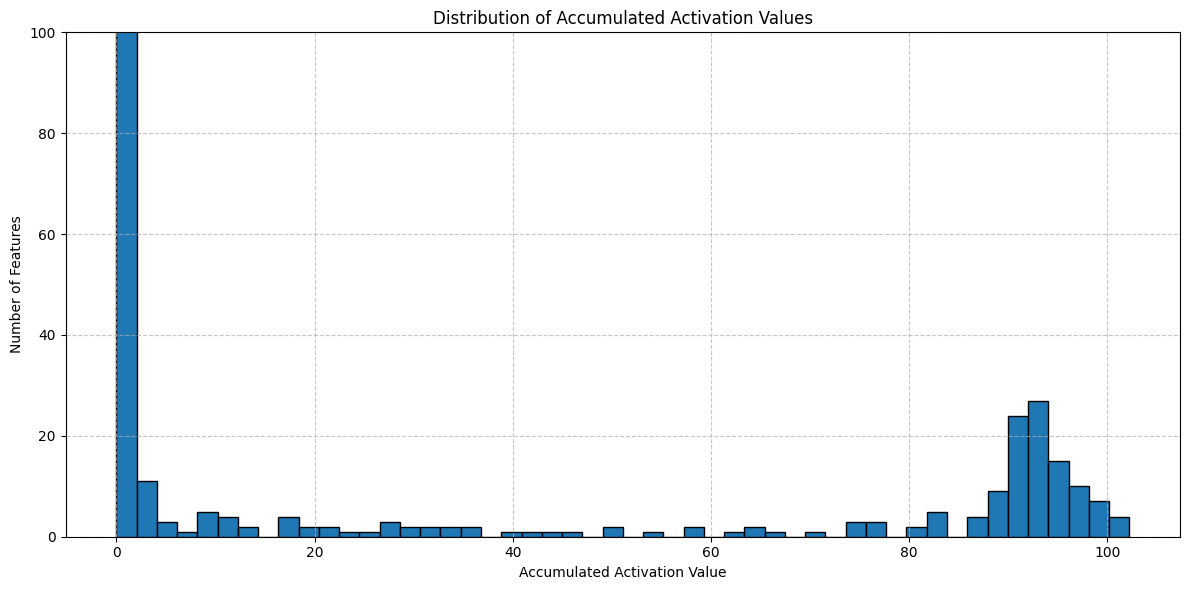

In [78]:
def plot_accumulated_activation_histogram(acc_features, num_bins=50):
    """
    Create a histogram of the accumulated activation value statistic.

    Args:
    acc_features (torch.Tensor): Tensor containing the accumulated activation values for each feature.
    num_bins (int): Number of bins for the histogram. Default is 50.

    Returns:
    None (displays the plot)
    """
    plt.figure(figsize=(12, 6))
    
    # Convert to numpy array if it's a torch tensor
    if isinstance(acc_features, torch.Tensor):
        acc_features = acc_features.cpu().numpy()
    
    # Create the histogram
    plt.hist(acc_features, bins=num_bins, edgecolor='black')
    
    # Set labels and title
    plt.xlabel('Accumulated Activation Value')
    plt.ylabel('Number of Features')
    plt.title('Distribution of Accumulated Activation Values')
    plt.ylim(0, 100)  # Set y-axis limit to 100
    
    # Add a grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Usage example:
plot_accumulated_activation_histogram(stats.acc_features)

In [79]:
def compute_acc_features_statistics(acc_features):
    # Convert to numpy if it's a torch tensor
    if isinstance(acc_features, torch.Tensor):
        acc_features = acc_features.cpu().numpy()

    stats = {
        "mean": np.mean(acc_features),
        "median": np.median(acc_features),
        "std": np.std(acc_features),
        "min": np.min(acc_features),
        "max": np.max(acc_features),
        "25th percentile": np.percentile(acc_features, 25),
        "75th percentile": np.percentile(acc_features, 75),
        "skewness": np.mean(
            ((acc_features - np.mean(acc_features)) / np.std(acc_features)) ** 3
        ),
        "kurtosis": np.mean(
            ((acc_features - np.mean(acc_features)) / np.std(acc_features)) ** 4
        )
        - 3,
        "non-zero count": np.count_nonzero(acc_features),
        "zero count": len(acc_features) - np.count_nonzero(acc_features),
    }

    return stats


# Compute and print the statistics
acc_features_stats = compute_acc_features_statistics(stats.acc_features)

for stat, value in acc_features_stats.items():
    print(f"{stat}: {value}")

mean: 0.4858034551143646
median: 0.0
std: 6.4104790687561035
min: 0.0
max: 102.20735931396484
25th percentile: 0.0
75th percentile: 0.0
skewness: 13.8754301071167
kurtosis: 194.04689025878906
non-zero count: 2786
zero count: 21790


In [80]:
# Usage example:
lambda_value = 1.0
rank_k_feature = 1
num_tokens = 1
exclude_first_k_tokens = 0

sample = tokenized.select(range(1000))["input_ids"]
inputs = {
    "input_ids": sample.cuda(),
    "attention_mask": torch.ones_like(sample, device="cuda:0"),
}

# Usage example:
num_layers = 6  # Adjust this based on your model's architecture
enc_binned_features, dec_binned_features = bin_features_by_layer(
    feature_encoder_weights, feature_decoder_weights, num_layers
)

layer_0_features = enc_binned_features[0]

for j, k in [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5)]:
    print(f"\nComputing causal attribution strength for j={j}, k={k}")
    results = compute_causal_attribution_strength(
        j,
        k,
        model,
        inputs,
        feature_encoder_weights,
        feature_encoder_bias,
        feature_decoder_weights,
        global_feature_activation_rate=stats.feature_activation_rate[layer_0_features],
        global_acc_feature_activations=None,
        lambda_value=lambda_value,
        rank_k_feature=rank_k_feature,
        num_tokens=num_tokens,
        exclude_first_k_tokens=exclude_first_k_tokens,
    )

    (
        proportion_explained,
        causal_cosine,
        error,
        relative_error,
        jacobian,
        v_j,
        v_k,
        is_valid,
    ) = results

    print(f"Mean proportion explained: {proportion_explained.mean()}")
    print(f"Mean causal cosine: {causal_cosine.mean()}")
    print(f"Mean error: {error.mean()}")
    print(f"Mean relative error: {relative_error.mean()}")
    print(f"Proportion of valid results: {is_valid.float().mean()}")


Computing causal attribution strength for j=0, k=1
Mean proportion explained: 0.20249620079994202
Mean causal cosine: 0.4083172380924225
Mean error: 0.0001639255351619795
Mean relative error: 0.0016424861969426274
Proportion of valid results: 0.7352031469345093

Computing causal attribution strength for j=1, k=2
Mean proportion explained: 0.1986674964427948
Mean causal cosine: 0.40199732780456543
Mean error: 0.0001650847989367321
Mean relative error: 0.0016541015356779099
Proportion of valid results: 0.8578594326972961

Computing causal attribution strength for j=2, k=3
Mean proportion explained: 0.19548511505126953
Mean causal cosine: 0.39701640605926514
Mean error: 0.00016597629291936755
Mean relative error: 0.0016630343161523342
Proportion of valid results: 0.7670313119888306

Computing causal attribution strength for j=3, k=4
Mean proportion explained: 0.19527076184749603
Mean causal cosine: 0.3980627655982971
Mean error: 0.00016570906154811382
Mean relative error: 0.0016603566473

In [81]:
[x.shape for x in enc_binned_features]

[torch.Size([21074]),
 torch.Size([1468]),
 torch.Size([538]),
 torch.Size([131]),
 torch.Size([1263]),
 torch.Size([102])]

In [82]:
def select_top_k_features(
    global_statistic, layer_features, top_k, use_accumulated=False
):
    """
    Select top k features based on either activation rate or accumulated activations.

    Args:
    global_statistic: Either global_feature_activation_rate or global_acc_feature_activations
    layer_features: Features for the current layer
    top_k: Number of top features to select
    use_accumulated: If True, use accumulated activations; otherwise, use activation rate

    Returns:
    Top k feature indices for the layer
    """
    # Get statistic for the features in this layer
    layer_statistic = global_statistic[layer_features]

    # Sort features by the statistic (descending) and select top k
    _, top_k_indices = torch.topk(layer_statistic, k=min(top_k, len(layer_features)))

    return layer_features[top_k_indices]


def run_layer_pair_evaluation_top_k(
    model,
    dataset,
    feature_encoder_weights,
    feature_encoder_bias,
    feature_decoder_weights,
    global_statistic,
    num_layers,
    binned_features,
    rank_k_feature=10,
    batch_size=128,
    lambda_value=1.0,
    num_tokens=1,
    exclude_first_k_tokens=0,
    use_accumulated=False,
    avg_over_bins=False,
):
    results = {layer: {} for layer in range(num_layers)}

    for layer in tqdm(range(num_layers), desc="Processing layers"):
        layer_features = binned_features[layer]
        if len(layer_features) == 0:
            continue

        _, top_k_indices = torch.topk(
            global_statistic[layer_features], k=rank_k_feature
        )

        # Select top k features for this layer bin
        if avg_over_bins:
            selected_features = layer_features[top_k_indices]
        else:
            selected_features = layer_features[top_k_indices[-1]]

        for i in range(num_layers):
            for j in range(i + 1, num_layers):
                layer_results = {
                    "causality": [],
                    "causal_cosines": [],
                    "errors": [],
                    "relative_errors": [],
                }

                for feature_idx in top_k_indices:
                    (
                        causality,
                        causal_cosines,
                        errors,
                        relative_errors,
                        _,
                        _,
                        _,
                        is_valid,
                    ) = compute_causal_attribution_strength(
                        j=i,
                        k=j,
                        model=model,
                        inputs={"input_ids": dataset["input_ids"].cuda()},
                        feature_encoder_weights=feature_encoder_weights,
                        feature_encoder_bias=feature_encoder_bias,
                        feature_decoder_weights=feature_decoder_weights,
                        global_feature_activation_rate=global_statistic[layer_features]
                        if not use_accumulated
                        else None,
                        global_acc_feature_activations=global_statistic[layer_features]
                        if use_accumulated
                        else None,
                        lambda_value=lambda_value,
                        rank_k_feature=feature_idx.item() + 1,
                        num_tokens=num_tokens,
                        exclude_first_k_tokens=exclude_first_k_tokens,
                    )

                    is_valid = is_valid.any(dim=1)

                    # Filter out invalid items and store results
                    if is_valid.any():
                        layer_results["causality"].append(
                            causality[is_valid].mean().item()
                        )
                        layer_results["causal_cosines"].append(
                            causal_cosines[is_valid].mean().item()
                        )
                        layer_results["errors"].append(errors[is_valid].mean().item())
                        layer_results["relative_errors"].append(
                            relative_errors[is_valid].mean().item()
                        )

                # Compute average for each metric
                results[layer][(i, j)] = {
                    metric: np.mean(values) if values else np.nan
                    for metric, values in layer_results.items()
                }
                results[layer][(i, j)]["feature_id"] = (
                    selected_features.tolist()
                    if avg_over_bins
                    else selected_features.item()
                )

        # Print diagonal results for each metric
        print(f"Diagonal results for layer {layer}:")
        for metric in ["causality", "causal_cosines", "errors"]:
            diagonal_values = [
                results[layer].get((i, i + 1), {}).get(metric, np.nan)
                for i in range(num_layers - 1)
            ]
            formatted_values = [
                f"{value:.4f}" if not np.isnan(value) else "N/A"
                for value in diagonal_values
            ]
            print(f"  {metric.capitalize()}: {formatted_values}")
        print()  # Add a blank line for readability

    return results


def plot_layer_heatmaps_top_k(results, num_layers, feature_decoder_weights, stats):
    for layer in range(num_layers):
        if not results[layer]:
            continue

        fig, axes = plt.subplots(1, 3, figsize=(20, 6))
        fig.suptitle(f"Layer {layer + 1} Heatmaps", fontsize=16)

        matrices = {
            "causal_cosines": np.full((num_layers, num_layers), np.nan),
            "causality": np.full((num_layers, num_layers), np.nan),
            "errors": np.full((num_layers, num_layers), np.nan),
        }

        feature_ids = {}
        for (i, j), values in results[layer].items():
            for metric in ["causal_cosines", "causality", "errors"]:
                matrices[metric][i, j] = values[metric]
            feature_ids[(i, j)] = values.get("feature_id", "N/A")

        # make sure all feature ids are same for all i,j
        assert all(
            feature_id == feature_ids[list(feature_ids.keys())[0]]
            for feature_id in feature_ids.values()
        )

        titles = ["Causal Cosines", "Causality", "Errors"]

        for col, (title, matrix) in enumerate(zip(titles, matrices.values())):
            ax = axes[col]

            # Create a mask for the lower triangle and diagonal
            mask = np.tril(np.ones_like(matrix, dtype=bool))

            vmin = 0
            vmax = np.nanmax(matrix)

            sns.heatmap(
                matrix,
                ax=ax,
                cmap="viridis",
                cbar=True,
                annot=True,
                fmt=".2f",
                mask=mask,
                vmin=vmin,
                vmax=vmax,
            )

            # feature id is same for all i,j here
            feature_id = feature_ids.get((i, j), "N/A")

            # Format feature_id if it's a long list
            if isinstance(feature_id, list):
                if len(feature_id) > 6:
                    feature_id_str = f"{feature_id[:3]}...{feature_id[-3:]}"
                else:
                    feature_id_str = str(feature_id)
            else:
                feature_id_str = str(feature_id)

            ax.set_title(f"{title}\nFeature ID: {feature_id_str}")
            ax.set_xlabel("Layer j")
            ax.set_ylabel("Layer i")

        plt.tight_layout()
        plt.show()


# Usage example:
num_layers = 6  # Adjust this based on your model's architecture
dataset_sample = tokenized.select(range(100))  # Adjust sample size as needed

run = False

if run:
    results = run_layer_pair_evaluation_top_k(
        model=model,
        dataset=dataset_sample,
        feature_encoder_weights=feature_encoder_weights,
        feature_encoder_bias=feature_encoder_bias,
        feature_decoder_weights=feature_decoder_weights,
        global_statistic=stats.feature_activation_rate,  # Or use stats.acc_features
        num_layers=num_layers,
        binned_features=enc_binned_features,
        rank_k_feature=20,
        batch_size=128,
        lambda_value=1.0,
        num_tokens=32,
        exclude_first_k_tokens=2,
        use_accumulated=False,  # Set to True if using accumulated activations
        avg_over_bins=True,
    )

    # Plot the heatmaps
    print(f"Plotting heatmaps for top {k} features:")
    plot_layer_heatmaps_top_k(results, num_layers, feature_decoder_weights, stats)

In [213]:
from functorch import vjp, vmap


def compute_jvp(model, j_activations, pos, j, k, v_j, sum_over_tokens=True):
    """
    Compute batched Jacobian-vector products (JVPs) of layer k's activations w.r.t. layer j's activations for select tokens.

    Args:
    - model: The language model (GPTNeoXModel or similar)
    - j_activations: Activations of layer j (shape: [batch_size, seq_len, hidden_size])
    - pos: Token positions (shape: [batch_size, num_selected_tokens])
    - j: Index of the input layer
    - k: Index of the output layer
    - v_j: The vector to compute the JVP with (shape: [batch_size, hidden_size])
    - sum_over_tokens: Whether to sum over tokens or not

    Returns:
    - Batch of JVPs
    """

    def get_layer_and_params(model, layer_idx):
        if "gpt2" in model.__class__.__name__.lower():
            layer = model.transformer.h[layer_idx]
        else:
            layer = model.gpt_neox.layers[layer_idx]
        return layer, dict(layer.named_parameters())

    def forward_to_k(x):
        activations = x[None, None, :]
        for layer_idx in range(j, k + 1):
            layer, params = get_layer_and_params(model, layer_idx)
            activations = functional_call(layer, params, activations)[0]
        return activations.squeeze()

    # Compute VJP for a single token
    def single_token_vjp(activation, v):
        _, vjp_fn = vjp(forward_to_k, activation)
        return vjp_fn(v)[0]

    # Flatten batch and sequence dimensions
    batch_size, seq_len, hidden_size = j_activations.shape
    flat_activations = j_activations.reshape(-1, hidden_size)

    # Expand v_j to match j_activations shape and then flatten
    flat_v_j = v_j.unsqueeze(1).expand(batch_size, seq_len, -1).reshape(-1, hidden_size)

    # Vmap over flattened batch and sequence dimensions
    flat_vjps = vmap(single_token_vjp)(flat_activations, flat_v_j)

    # Reshape back to original dimensions
    all_vjps = flat_vjps.reshape(batch_size, seq_len, hidden_size)

    if sum_over_tokens:
        return all_vjps.sum(dim=1)
    else:
        return all_vjps

torch.Size([1, 16, 512]) torch.Size([16, 512])
torch.Size([1, 16, 512]) torch.Size([16, 512])
torch.Size([1, 16, 512]) torch.Size([16, 512])
torch.Size([1, 16, 512]) torch.Size([16, 512])
torch.Size([1, 16, 512]) torch.Size([16, 512])
torch.Size([1, 16, 512]) torch.Size([16, 512])
torch.Size([1, 16, 512]) torch.Size([16, 512])
torch.Size([1, 16, 512]) torch.Size([16, 512])


/home/sid/miniconda3/envs/sae/lib/python3.10/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')
/home/sid/miniconda3/envs/sae/lib/python3.10/site-packages/torch/_functorch/deprecated.py:73: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vjp is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.vjp instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vjp')


torch.Size([1, 16, 512]) torch.Size([16, 512])
torch.Size([1, 16, 512]) torch.Size([16, 512])
torch.Size([1, 16, 512]) torch.Size([16, 512])
torch.Size([1, 16, 512]) torch.Size([16, 512])
torch.Size([1, 16, 512]) torch.Size([16, 512])
torch.Size([1, 16, 512]) torch.Size([16, 512])
torch.Size([1, 16, 512]) torch.Size([16, 512])
Trigger layer 0, valid tokens (limited to 5): tensor([0, 1, 3, 4, 6], device='cuda:0')


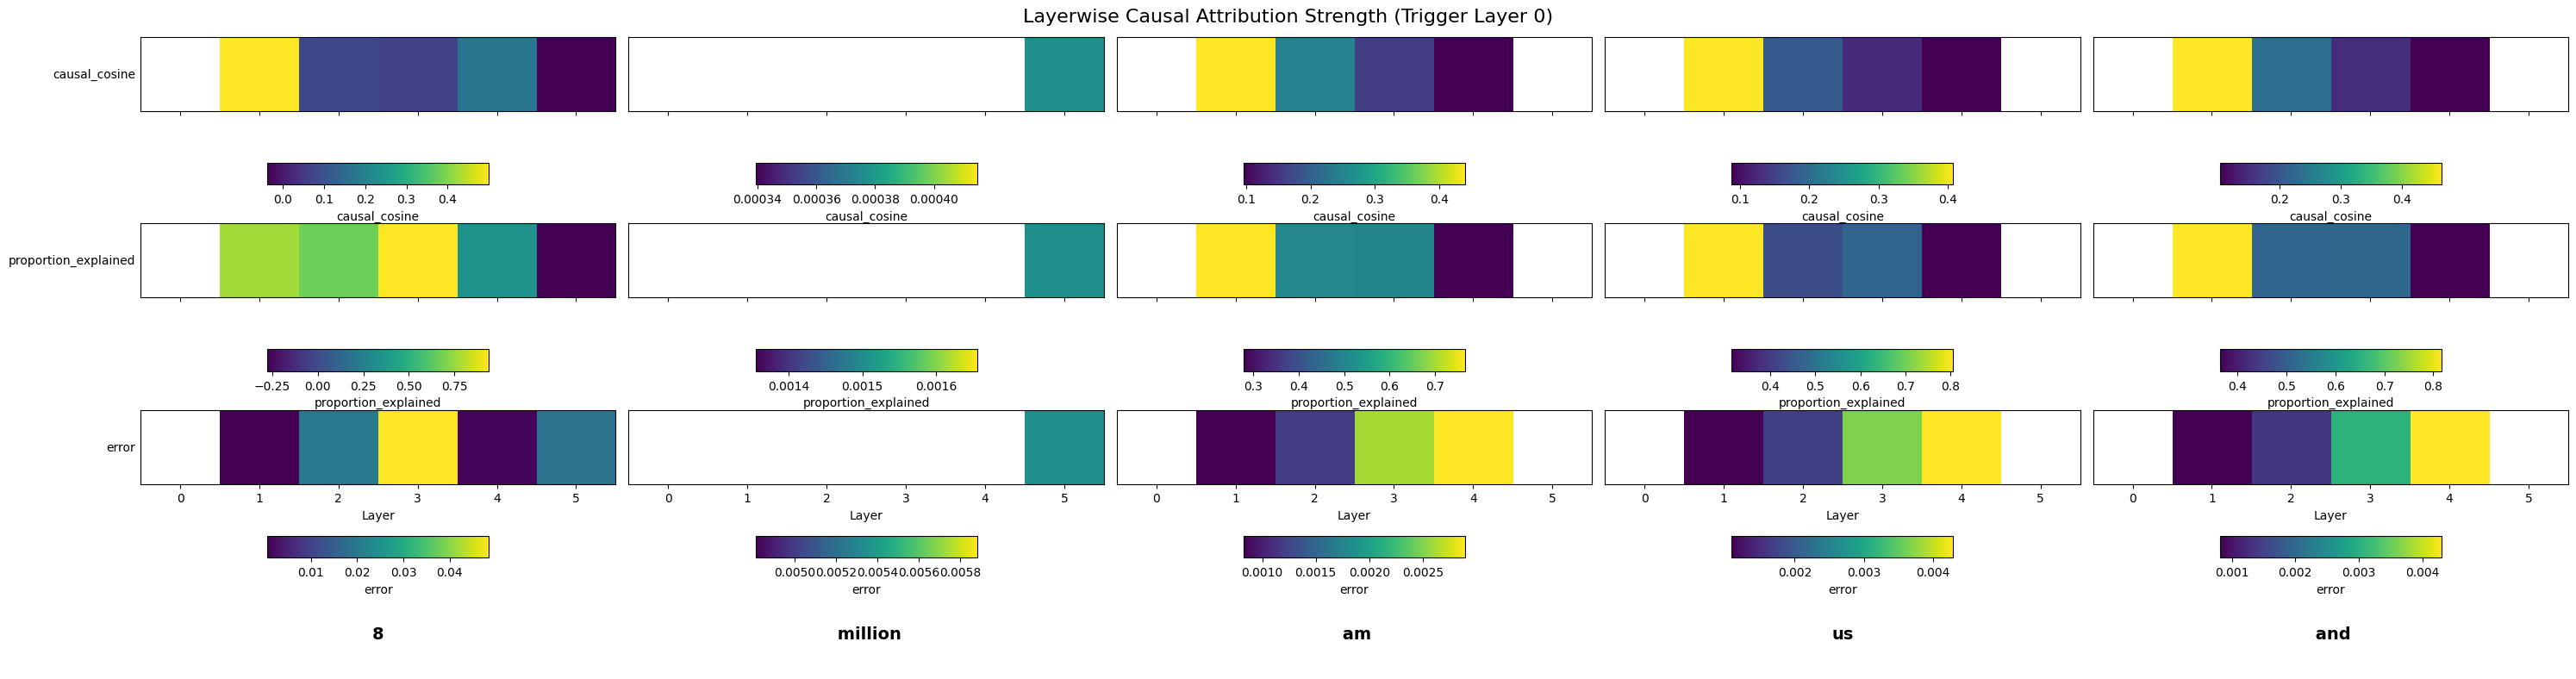

Trigger layer 1, valid tokens (limited to 5): tensor([0, 1, 3, 4, 5], device='cuda:0')


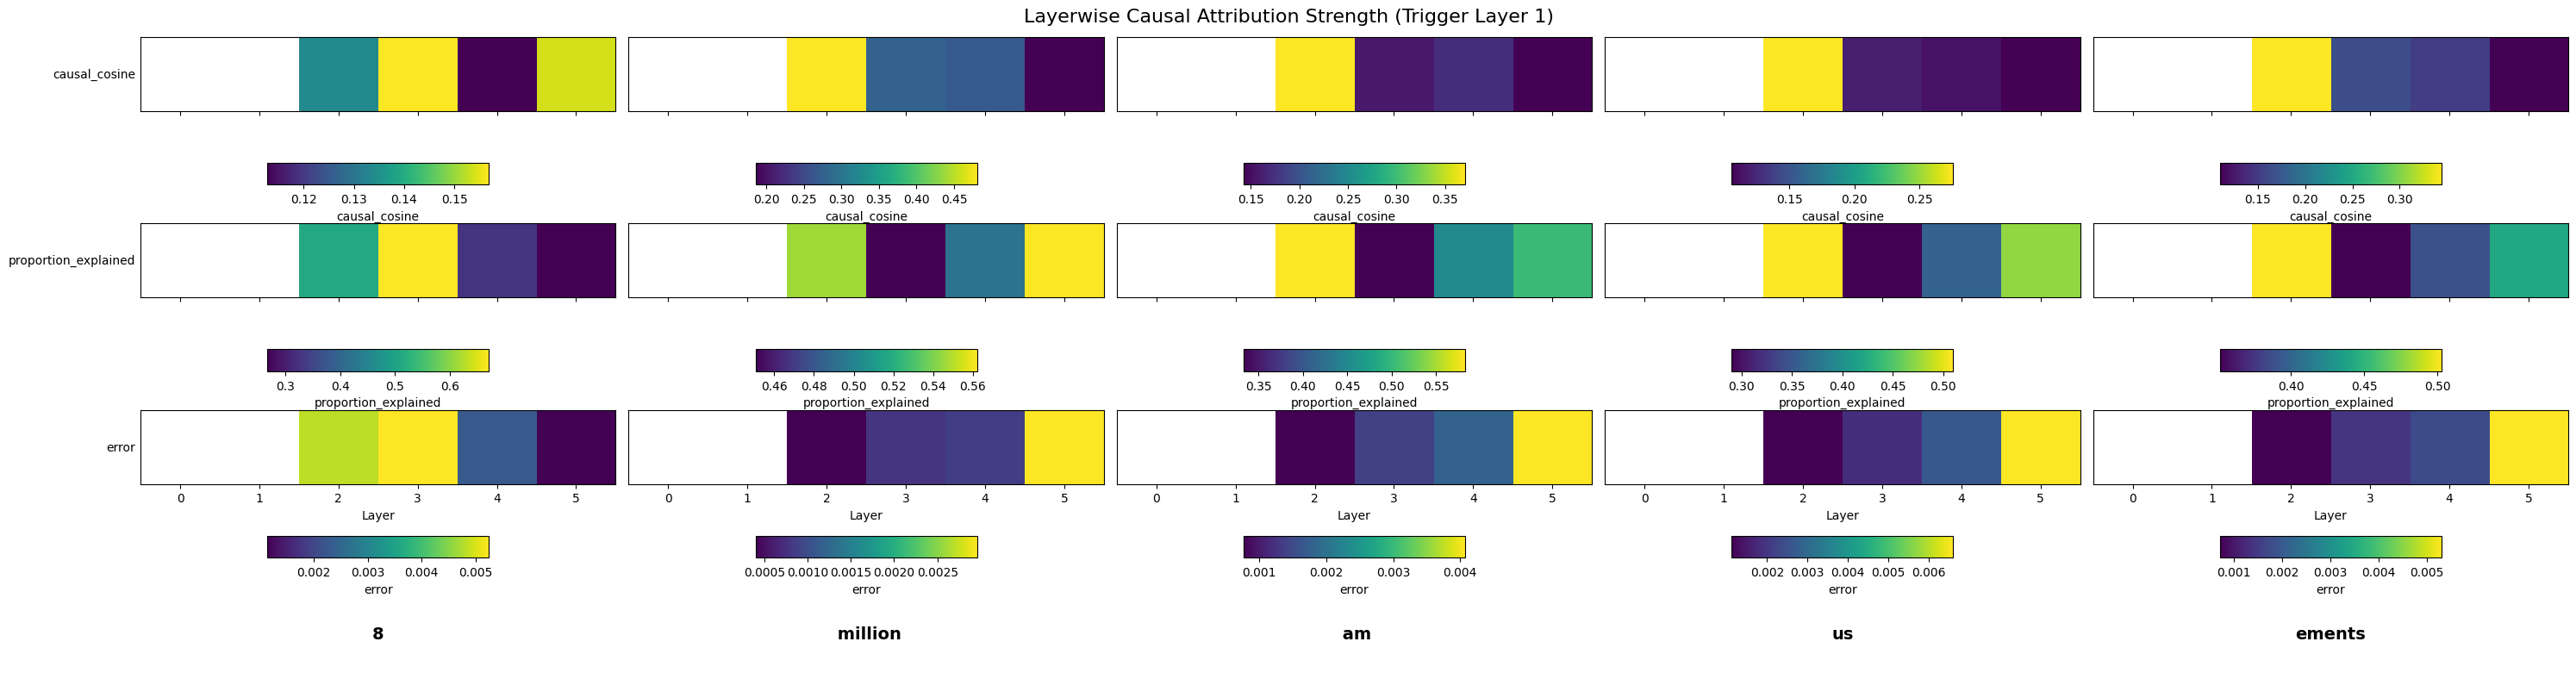

Trigger layer 2, valid tokens (limited to 5): tensor([0, 1, 2, 3, 5], device='cuda:0')


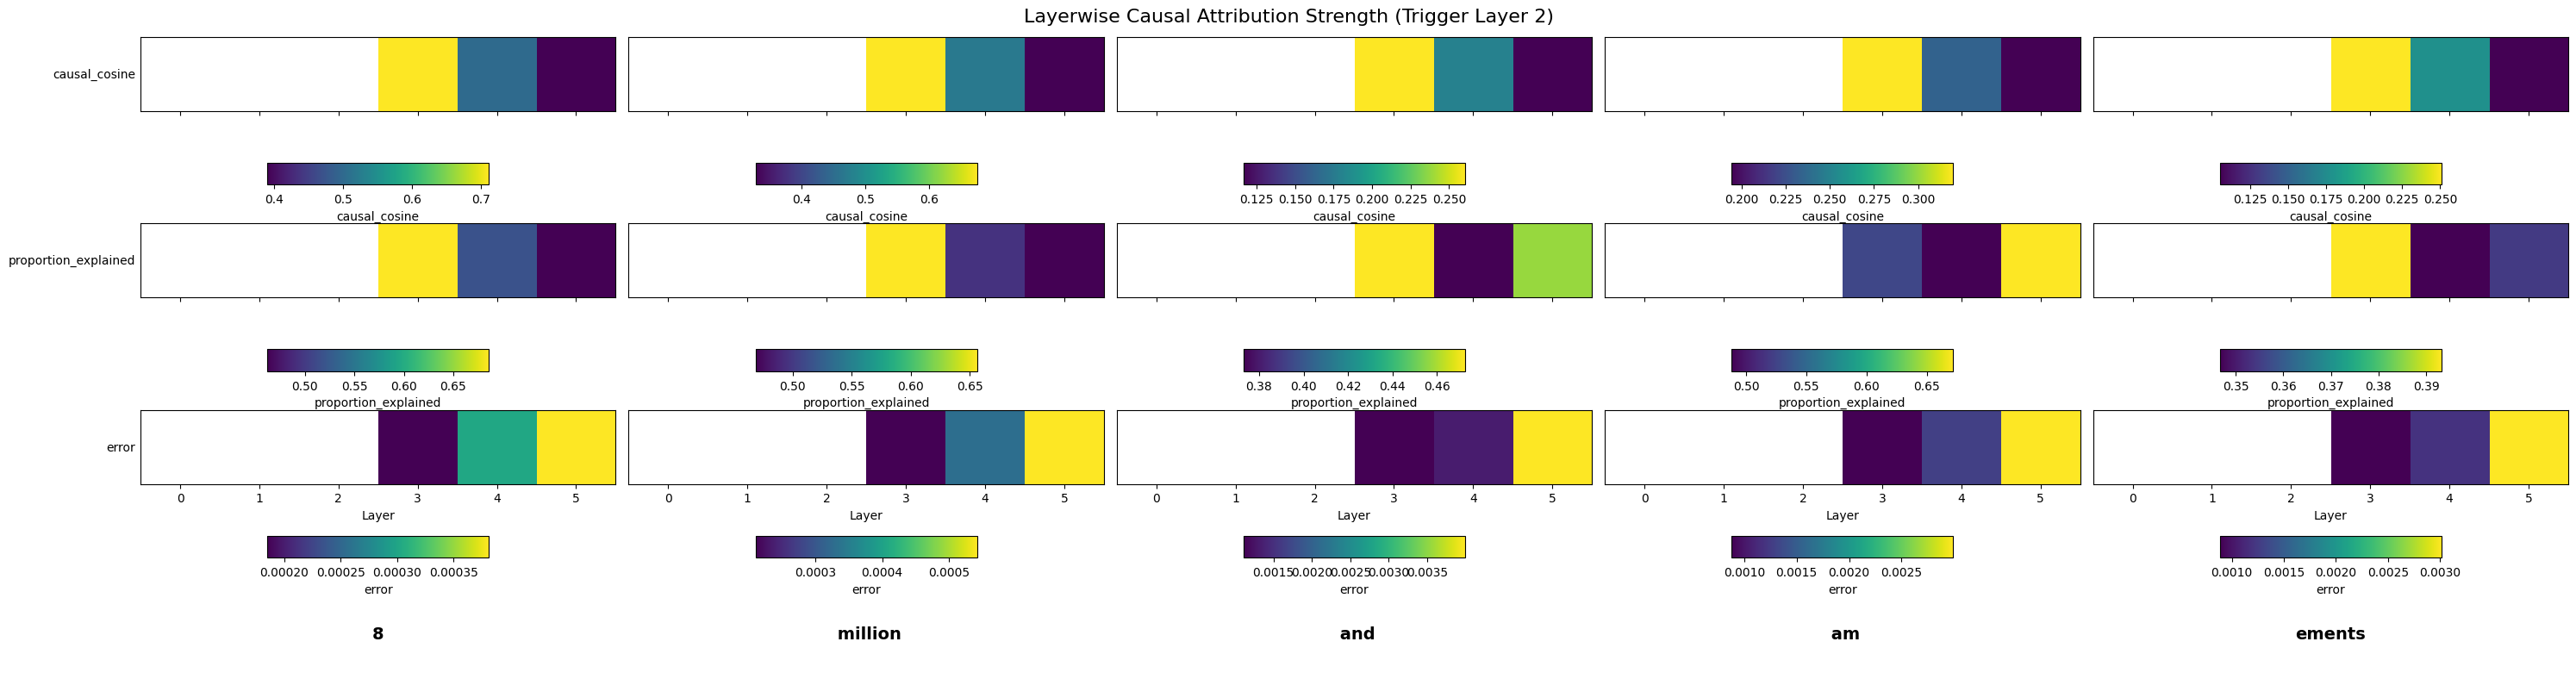

Trigger layer 3, valid tokens (limited to 5): tensor([0, 1, 2, 3, 5], device='cuda:0')


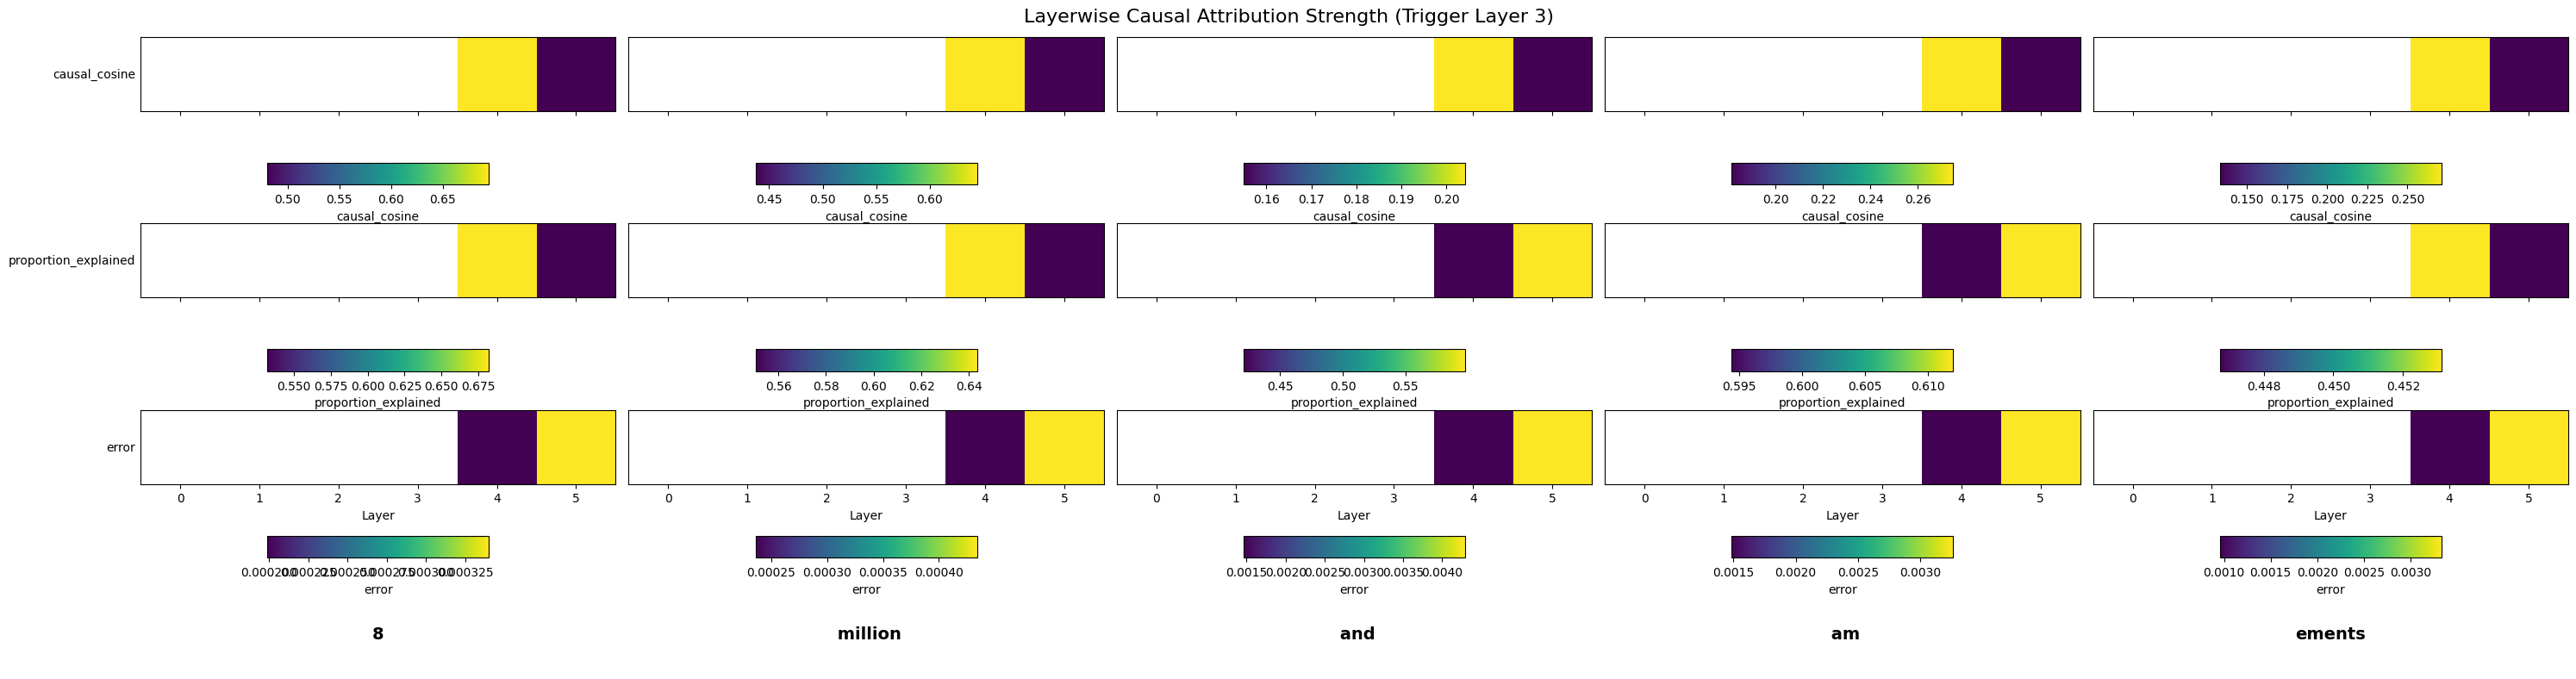

Trigger layer 4, valid tokens (limited to 5): tensor([ 0,  1,  2,  3, 11], device='cuda:0')


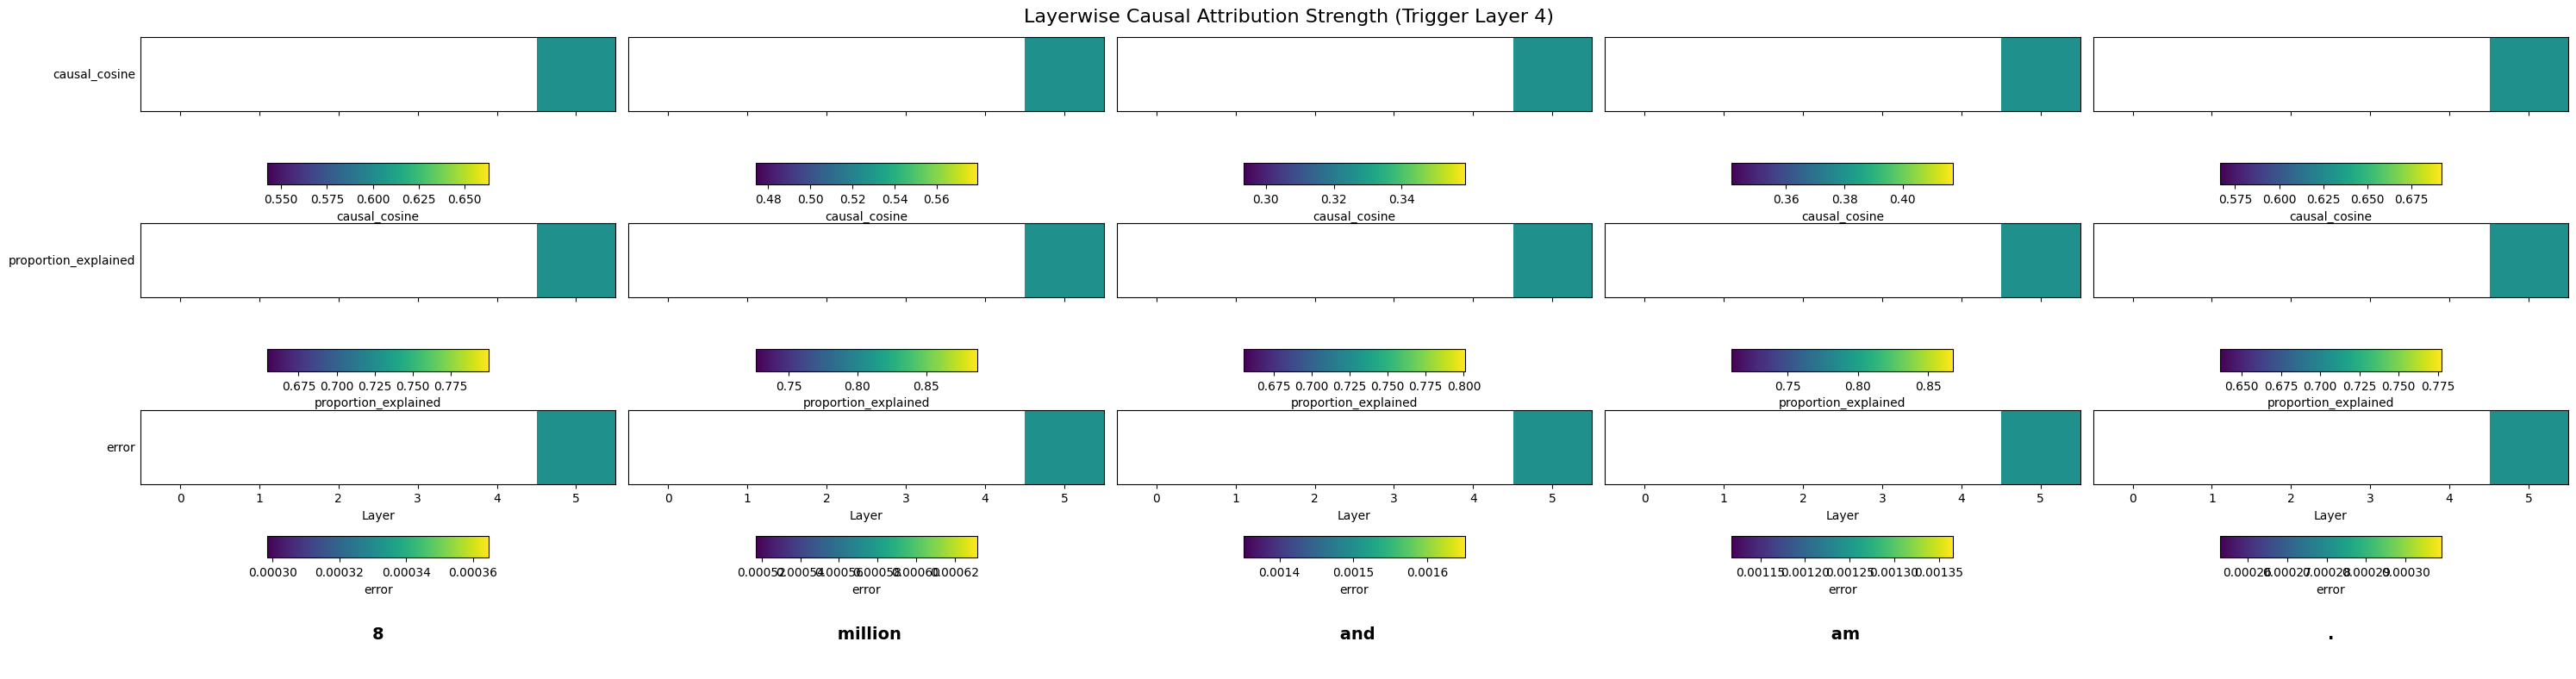

In [208]:
import random


@torch.no_grad()
def compute_per_token_causal_attribution_strength(
    j: int,
    k: int,
    model: torch.nn.Module,
    inputs: Dict[str, torch.Tensor],
    feature_encoder_weights: torch.Tensor,
    feature_encoder_bias: torch.Tensor,
    feature_decoder_weights: torch.Tensor,
    global_feature_activation_rate: torch.Tensor,
    global_acc_feature_activations: torch.Tensor,
    lambda_value: float = 1.0,
    rank_k_feature: int = 1,
    exclude_first_k_tokens: int = 0,
    sae_top_k: int = 128,
):
    # Add batch dimension if input is not batched
    if inputs["input_ids"].dim() == 1:
        inputs = {key: value.unsqueeze(0) for key, value in inputs.items()}

    intervention = perform_intervention(
        model=model,
        batch=inputs,
        global_feature_activation_rate=global_feature_activation_rate,
        global_acc_feature_activations=global_acc_feature_activations,
        intervention_index=j,
        readout_index=k,
        feature_encoder_weights=feature_encoder_weights,
        feature_encoder_bias=feature_encoder_bias,
        feature_decoder_weights=feature_decoder_weights,
        lambda_value=lambda_value,
        num_tokens=inputs["input_ids"].shape[1] - exclude_first_k_tokens,
        feature_top_k=rank_k_feature,
        exclude_first_k_tokens=exclude_first_k_tokens,
        sae_top_k=sae_top_k,
    )

    # Compute JVP
    jvp = compute_jvp(
        model,
        intervention.clean_base_outputs,
        intervention.activation_positions,
        j,
        k,
        intervention.v_j,
        sum_over_tokens=False,
    )

    if jvp.dim() == 2:
        jvp = jvp.unsqueeze(0)

    v_k_norm_squared = torch.norm(intervention.v_k, p=2, dim=-1).pow(2)

    # Compute metrics for all tokens in the batch
    proportion_explained = (
        torch.einsum("bsh,bh->bs", jvp, intervention.v_k.squeeze(1)) / v_k_norm_squared
    )
    causal_cosine = F.cosine_similarity(
        jvp, intervention.v_k.unsqueeze(1).expand_as(jvp), dim=-1
    )
    error = torch.mean(
        (jvp - intervention.v_k.unsqueeze(1).expand_as(jvp)) ** 2, dim=-1
    )
    relative_error = error / v_k_norm_squared.unsqueeze(1)

    # Mask out invalid tokens
    mask = intervention.is_valid.squeeze()
    proportion_explained = proportion_explained.masked_fill(~mask, float("nan"))
    causal_cosine = causal_cosine.masked_fill(~mask, float("nan"))
    error = error.masked_fill(~mask, float("nan"))
    relative_error = relative_error.masked_fill(~mask, float("nan"))

    return {
        "proportion_explained": proportion_explained.squeeze(),
        "causal_cosine": causal_cosine.squeeze(),
        "error": error.squeeze(),
        "relative_error": relative_error.squeeze(),
        "is_valid": intervention.is_valid.squeeze(),
    }


def plot_single_example_causal_attribution(
    results: Dict[str, torch.Tensor],
    tokenizer,
    input_ids: torch.Tensor,
    num_layers: int,
    exclude_first_k_tokens: int = 0,
    max_tokens: int = 5,
):
    metrics = ["causal_cosine", "proportion_explained", "error"]
    num_tokens = input_ids.shape[1] - exclude_first_k_tokens

    token_labels = tokenizer.batch_decode(
        input_ids[0, exclude_first_k_tokens:].unsqueeze(-1)
    )

    for i in range(num_layers - 1):  # Trigger layer
        # Get valid tokens for this trigger layer
        is_valid = torch.zeros(num_tokens, dtype=torch.bool, device=input_ids.device)
        for j in range(i + 1, num_layers):
            key = f"{i}_{j}"
            if key in results["is_valid"]:
                is_valid |= results["is_valid"][key]

        valid_tokens = torch.arange(num_tokens, device=is_valid.device)[is_valid]

        if len(valid_tokens) == 0:
            print(f"No valid tokens for trigger layer {i}. Skipping.")
            continue

        # Limit the number of valid tokens to max_tokens
        valid_tokens = valid_tokens[:max_tokens]
        print(
            f"Trigger layer {i}, valid tokens (limited to {max_tokens}):", valid_tokens
        )

        # Create a figure with subplots for each metric and token
        fig, axes = plt.subplots(
            4,
            len(valid_tokens),
            figsize=(6 * len(valid_tokens), 8),
            gridspec_kw={
                "height_ratios": [1, 1, 1, 0.5]
            },  # Adjust the ratio for token labels
        )
        fig.suptitle(
            f"Layerwise Causal Attribution Strength (Trigger Layer {i})", fontsize=16
        )

        for col, token_idx in enumerate(valid_tokens):
            token = token_labels[token_idx]

            for row, metric in enumerate(metrics):
                ax = axes[row, col] if len(valid_tokens) > 1 else axes[row]

                # Create a vector for the layerwise similarity
                similarity_vector = np.full(num_layers, np.nan)
                for j in range(i + 1, num_layers):
                    key = f"{i}_{j}"
                    if key in results[metric]:
                        similarity_vector[j] = results[metric][key][token_idx].item()

                # Plot the similarity vector as a horizontal colorbar
                im = ax.imshow(
                    similarity_vector[np.newaxis, :], aspect="auto", cmap="viridis"
                )
                ax.set_yticks([])
                ax.set_xticks(range(num_layers))

                if row == len(metrics) - 1:
                    ax.set_xlabel("Layer")
                else:
                    ax.set_xticklabels([])

                # Add a colorbar
                plt.colorbar(
                    im,
                    ax=ax,
                    orientation="horizontal",
                    label=metric,
                    aspect=10,
                    pad=0.35,
                )

                if col == 0:
                    ax.set_ylabel(metric, rotation=0, ha="right", va="center")

            # Add token labels at the bottom
            ax_token = axes[-1, col] if len(valid_tokens) > 1 else axes[-1]
            ax_token.axis("off")
            ax_token.text(
                0.5,
                0.5,
                token,
                ha="center",
                va="center",
                fontweight="bold",
                fontsize=14,
            )

        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)  # Adjust the vertical space between subplots
        plt.show()


# Example usage:
num_layers = 6
exclude_first_k_tokens = 0
inputs = random.choice(tokenized)
inputs = {"input_ids": inputs["input_ids"][:16].cuda().unsqueeze(0)}


results = {
    metric: {}
    for metric in ["causal_cosine", "proportion_explained", "error", "is_valid"]
}

for i in range(num_layers - 1):
    for j in range(i + 1, num_layers):
        layer_results = compute_per_token_causal_attribution_strength(
            i,
            j,
            model,
            inputs,
            feature_encoder_weights,
            feature_encoder_bias,
            feature_decoder_weights,
            stats.feature_activation_rate,
            stats.acc_features,
            lambda_value=1.0,
            rank_k_feature=10,
            exclude_first_k_tokens=exclude_first_k_tokens,
        )

        for metric in results:
            results[metric][f"{i}_{j}"] = layer_results[metric]

plot_single_example_causal_attribution(
    results, tokenizer, inputs["input_ids"], num_layers, exclude_first_k_tokens
)

In [193]:
torch.cuda.empty_cache()
gc.collect()

167483

Processing i=0, j=1:   0%|          | 0/2 [00:00<?, ?it/s]/home/sid/miniconda3/envs/sae/lib/python3.10/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')
/home/sid/miniconda3/envs/sae/lib/python3.10/site-packages/torch/_functorch/deprecated.py:73: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vjp is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.vjp instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/doc

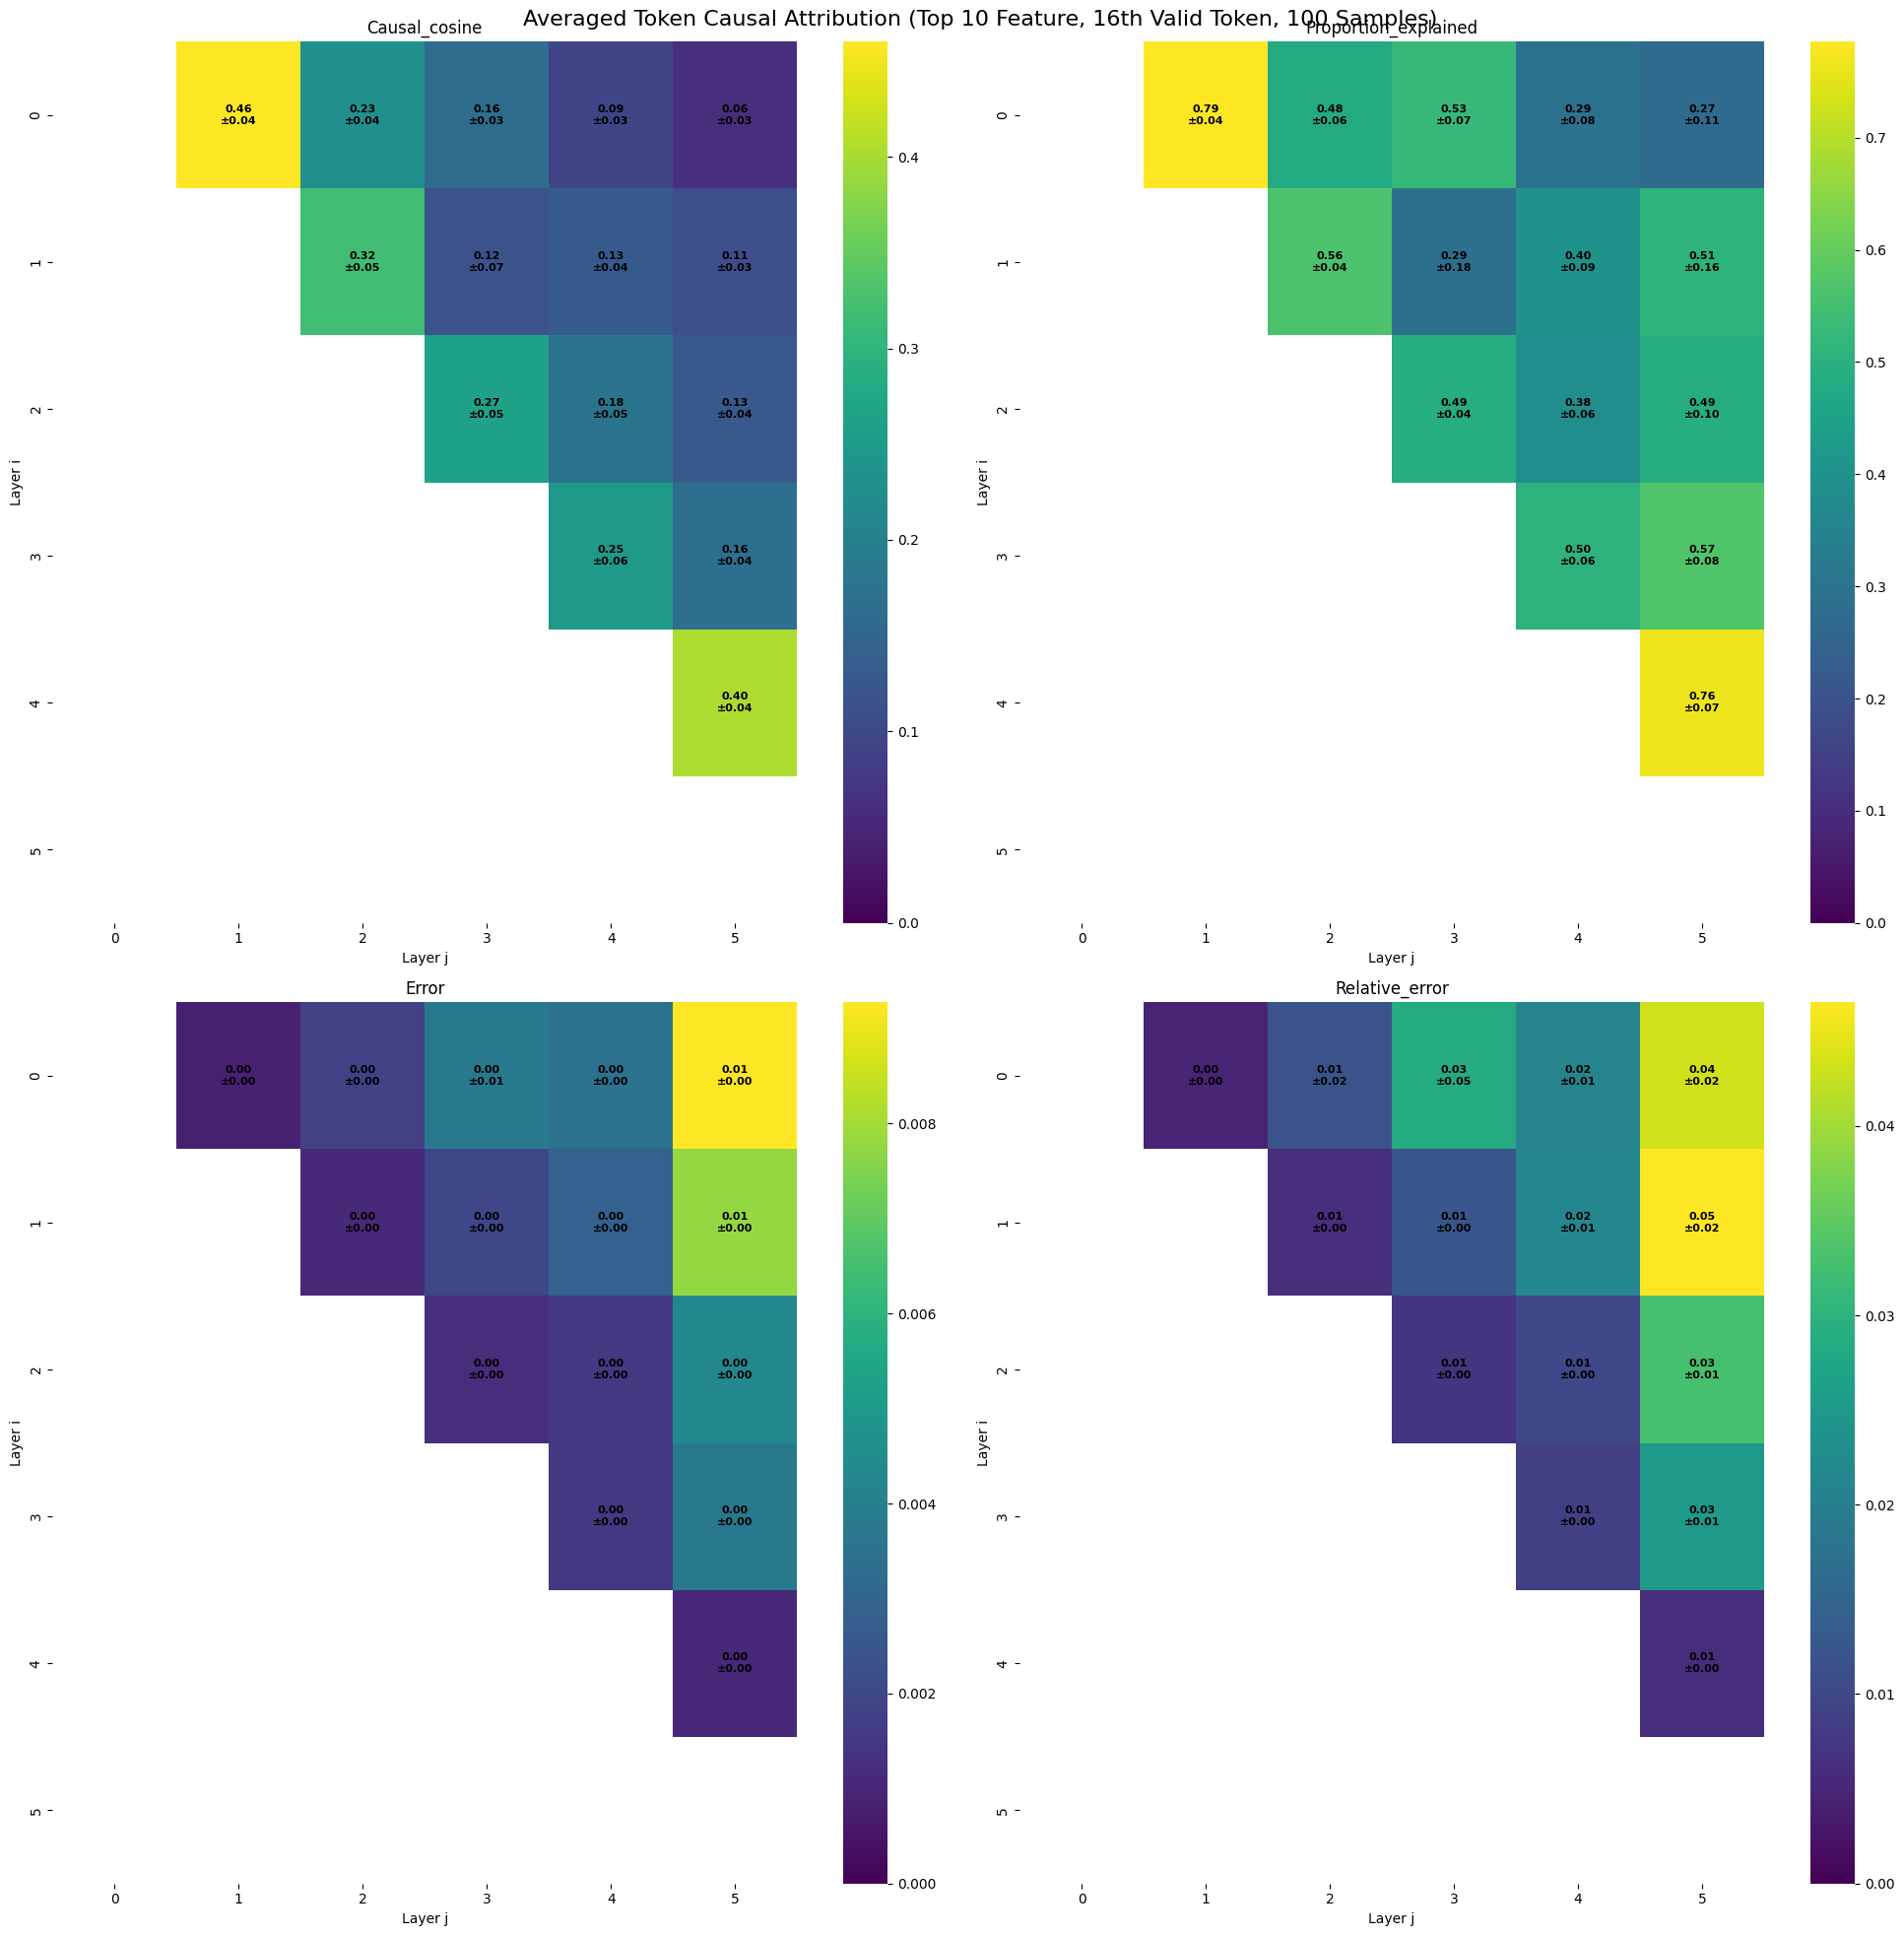

In [214]:
def plot_averaged_token_causal_attribution(
    model,
    dataset,
    feature_encoder_weights,
    feature_encoder_bias,
    feature_decoder_weights,
    global_feature_activation_rate,
    global_acc_feature_activations,
    num_layers,
    k_feature=1,
    n_token=1,  # New parameter for selecting the nth valid token
    lambda_value=1.0,
    exclude_first_k_tokens=0,
    sae_top_k=128,
    batch_size=8,
    num_samples=100,
    process_tokens=6,
):
    dataloader = DataLoader(
        dataset.select(range(num_samples)), batch_size=batch_size, shuffle=False
    )

    metrics = ["causal_cosine", "proportion_explained", "error", "relative_error"]
    results = {metric: np.zeros((num_layers, num_layers)) for metric in metrics}
    std_results = {metric: np.zeros((num_layers, num_layers)) for metric in metrics}

    for i in range(num_layers - 1):
        for j in range(i + 1, num_layers):
            metric_values = {metric: [] for metric in metrics}

            for batch in tqdm(dataloader, desc=f"Processing i={i}, j={j}"):
                inputs = {"input_ids": batch["input_ids"][:, :process_tokens].cuda()}

                layer_results = compute_per_token_causal_attribution_strength(
                    i,
                    j,
                    model,
                    inputs,
                    feature_encoder_weights,
                    feature_encoder_bias,
                    feature_decoder_weights,
                    global_feature_activation_rate,
                    global_acc_feature_activations,
                    lambda_value=lambda_value,
                    rank_k_feature=k_feature,
                    exclude_first_k_tokens=exclude_first_k_tokens,
                    sae_top_k=sae_top_k,
                )

                for metric in metrics:
                    for example_idx in range(inputs["input_ids"].shape[0]):
                        valid_indices = layer_results["is_valid"][example_idx].nonzero(
                            as_tuple=True
                        )[0]
                        if len(valid_indices) >= n_token:
                            nth_valid_token = valid_indices[n_token - 1]
                            metric_values[metric].append(
                                layer_results[metric][
                                    example_idx, nth_valid_token
                                ].item()
                            )

            for metric in metrics:
                if metric_values[metric]:
                    results[metric][i, j] = np.mean(metric_values[metric])
                    std_results[metric][i, j] = np.std(metric_values[metric])

    # Mask out bottom triangle and diagonal with NaNs
    for metric in metrics:
        mask = np.tril(np.ones_like(results[metric]))
        results[metric] = np.where(mask, np.nan, results[metric])
        std_results[metric] = np.where(mask, np.nan, std_results[metric])

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    fig.suptitle(
        f"Averaged Token Causal Attribution (Top {k_feature} Feature, {n_token}th Valid Token, {num_samples} Samples)",
        fontsize=16,
    )

    for idx, metric in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]

        # Create a mask for the lower triangle and diagonal
        mask = np.tril(np.ones_like(results[metric]))

        # Plot mean values
        sns.heatmap(
            results[metric],
            ax=ax,
            cmap="viridis",
            annot=False,  # Don't annotate here, we'll do it manually
            cbar=True,
            mask=mask,
            vmin=0,  # Adjust as needed
            vmax=np.nanmax(results[metric]),  # Adjust as needed
        )

        # Add mean and std dev annotations
        for i in range(num_layers):
            for j in range(i + 1, num_layers):
                mean_value = results[metric][i, j]
                std_value = std_results[metric][i, j]
                ax.text(
                    j + 0.5,
                    i + 0.5,
                    f"{mean_value:.2f}\n±{std_value:.2f}",
                    ha="center",
                    va="center",
                    color="black",
                    fontsize=8,
                    weight="bold",
                )

        ax.set_title(f"{metric.capitalize()}")
        ax.set_xlabel("Layer j")
        ax.set_ylabel("Layer i")

    plt.tight_layout()
    plt.show()


# Usage example:
plot_averaged_token_causal_attribution(
    model=model,
    dataset=tokenized,
    feature_encoder_weights=feature_encoder_weights,
    feature_encoder_bias=feature_encoder_bias,
    feature_decoder_weights=feature_decoder_weights,
    global_feature_activation_rate=stats.feature_activation_rate,
    global_acc_feature_activations=stats.acc_features,
    num_layers=6,
    k_feature=10,
    n_token=16,
    lambda_value=1.0,
    exclude_first_k_tokens=0,
    sae_top_k=128,
    batch_size=64,
    num_samples=100,
    process_tokens=64,
)

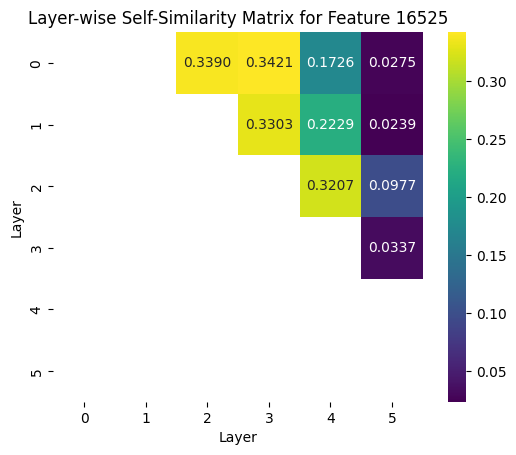

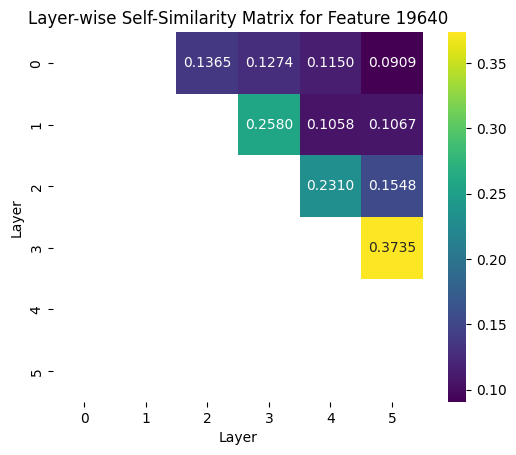

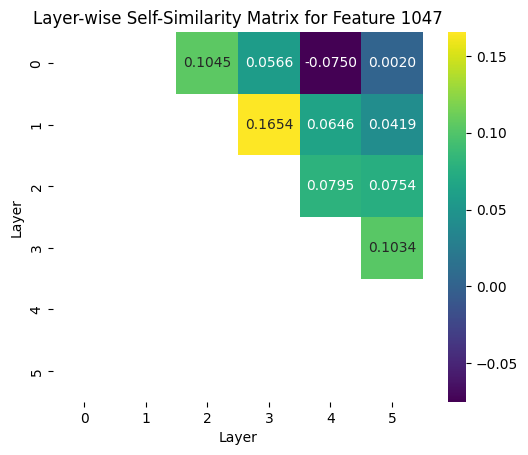

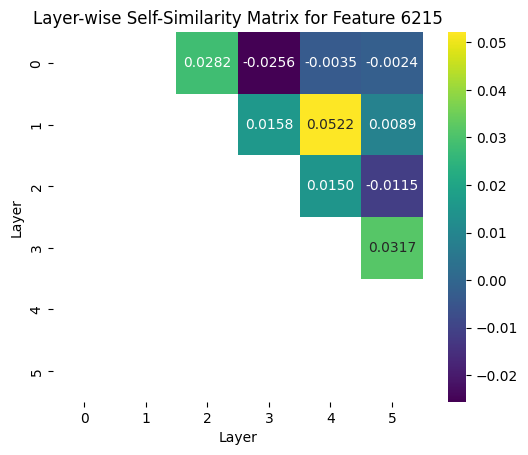

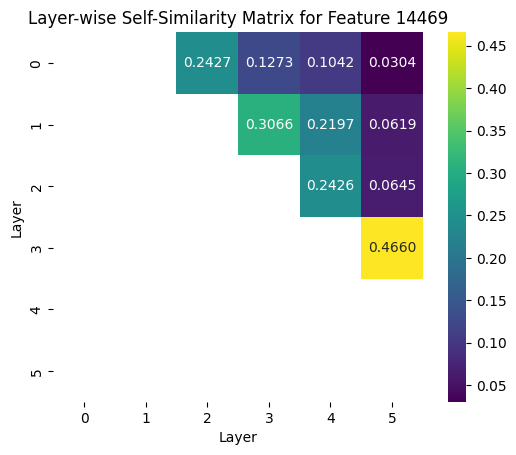

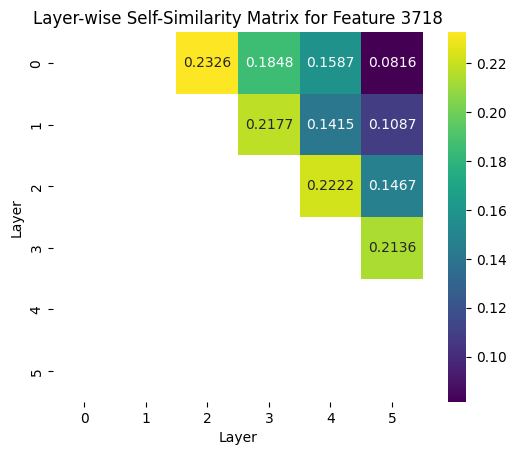

In [43]:
import random


def plot_layer_wise_self_similarity(
    decoder_weights, layer_bin, num_layers=6, hidden_size=512
):
    # Select a random feature from the specified layer bin
    feature_idx = random.choice(layer_bin)

    # Extract the decoder vector for this feature
    feature_vector = decoder_weights[feature_idx]

    # Split the vector into layer-wise chunks
    layer_chunks = torch.stack(torch.split(feature_vector, hidden_size))

    # Compute the similarity matrix using vectorized operations
    similarity_matrix = torch.nn.functional.cosine_similarity(
        layer_chunks.unsqueeze(1), layer_chunks.unsqueeze(0), dim=2
    )

    # Create a mask for the lower triangle
    mask = np.tril(np.ones_like(similarity_matrix.cpu().numpy(), dtype=bool), k=1)

    # Plot the similarity matrix
    plt.figure()
    sns.heatmap(
        similarity_matrix.cpu().numpy(),
        cmap="viridis",
        annot=True,
        fmt=".4f",  # Increase precision
        square=True,
        cbar=True,
        mask=mask,  # Apply the mask
    )
    plt.title(f"Layer-wise Self-Similarity Matrix for Feature {feature_idx}")
    plt.xlabel("Layer")
    plt.ylabel("Layer")

    plt.show()


# Run for multiple features
for i in range(6):
    plot_layer_wise_self_similarity(feature_decoder_weights, enc_binned_features[i])

### Empirical Analysis of Encoder/Decoder Norms


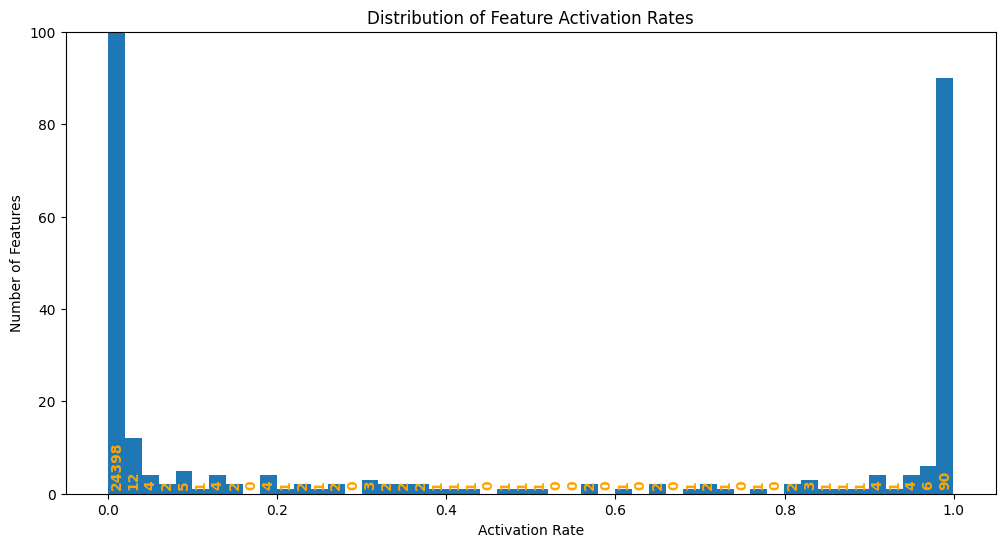

In [22]:
def plot_feature_activation_distribution(global_feature_activation_rate):
    plt.figure(figsize=(12, 6))
    
    # Create histogram and get the frequency data
    n, bins, patches = plt.hist(global_feature_activation_rate.cpu().numpy(), bins=50)
    
    # Label each bar with its frequency, bold and inside the bar
    for i, v in enumerate(n):
        plt.text(bins[i] + (bins[i+1] - bins[i])/2, 1, str(int(v)), 
                 ha='center', va='bottom', rotation=90, 
                 fontweight='bold', color='orange')
    
    plt.title("Distribution of Feature Activation Rates")
    plt.xlabel("Activation Rate")
    plt.ylabel("Number of Features")
    plt.ylim(0, 100)  # Set y-axis limit to 100
    plt.show()

# Usage:
plot_feature_activation_distribution(stats.feature_activation_rate)

In [23]:
def filter_inactive_features(
    feature_activation_rate,
    feature_encoder_weights,
    feature_encoder_bias,
    feature_decoder_weights,
    min_activation_rate=0.01,
):
    """
    Filter out features with activation rates below the specified threshold.

    Args:
    feature_activation_rate (torch.Tensor): Tensor of feature activation rates.
    feature_encoder_weights (torch.Tensor): Encoder weights.
    feature_encoder_bias (torch.Tensor): Encoder bias.
    feature_decoder_weights (torch.Tensor): Decoder weights.
    min_activation_rate (float): Minimum activation rate threshold. Default is 0.01.

    Returns:
    tuple: Filtered versions of encoder weights, encoder bias, and decoder weights.
    """
    # Identify features with activation rate above the threshold
    active_features = torch.where(feature_activation_rate > min_activation_rate)[0]

    # Create filtered versions of encoder and decoder components
    filtered_feature_encoder_weights = feature_encoder_weights[active_features]
    filtered_feature_encoder_bias = feature_encoder_bias[active_features]
    filtered_feature_decoder_weights = feature_decoder_weights[active_features]

    return (
        filtered_feature_encoder_weights,
        filtered_feature_encoder_bias,
        filtered_feature_decoder_weights,
    )


def calculate_layer_norms(weights, num_layers):
    """Calculate norms for each layer of the given weights."""
    layer_size = weights.shape[1] // num_layers
    layer_weights = torch.split(weights, layer_size, dim=1)
    return torch.stack([layer.norm(dim=1) for layer in layer_weights])


def filter_features_by_layer(encoder_norms, decoder_norms, layer_index):
    """Filter features where the specified layer has the largest norm."""
    max_norm_layers = encoder_norms.argmax(dim=0)
    layer_mask = max_norm_layers == layer_index
    return encoder_norms[:, layer_mask], decoder_norms[:, layer_mask], layer_mask


def create_norm_heatmap(norms, title, ax):
    """Create a heatmap of norms with layers on the vertical axis."""
    sns.heatmap(norms.cpu().numpy(), cmap="viridis", cbar=True, ax=ax)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("Feature Index", fontsize=8)
    ax.set_ylabel("Layer", fontsize=8)
    ax.tick_params(labelsize=6)


def plot_layerwise_filtering(
    encoder_weights,
    decoder_weights,
    num_layers,
    feature_activation_rate,
    save_folder=None,
    norm_threshold=0.01,
    activation_threshold=0.0,
):
    encoder_norms = calculate_layer_norms(encoder_weights, num_layers)
    decoder_norms = calculate_layer_norms(decoder_weights, num_layers)

    print(
        f"Initial shapes - Encoder: {encoder_norms.shape}, Decoder: {decoder_norms.shape}"
    )

    # Sort features by activation rate, but only for the filtered features
    sorted_indices = torch.argsort(
        feature_activation_rate[feature_activation_rate > activation_threshold],
        descending=True,
    )
    encoder_norms = encoder_norms[:, sorted_indices]
    decoder_norms = decoder_norms[:, sorted_indices]

    # Initial plot
    fig_initial = plt.figure(figsize=(16, 7))
    ax1 = fig_initial.add_subplot(121)
    ax2 = fig_initial.add_subplot(122)
    create_norm_heatmap(
        encoder_norms, "Initial Encoder Norms (Sorted by Activation Rate)", ax1
    )
    create_norm_heatmap(
        decoder_norms, "Initial Decoder Norms (Sorted by Activation Rate)", ax2
    )
    plt.tight_layout()
    if save_folder:
        plt.savefig(
            os.path.join(save_folder, "initial_norms_sorted.png"),
            dpi=300,
            bbox_inches="tight",
        )
    plt.show()

    for i in range(num_layers):
        (filtered_encoder_norms, filtered_decoder_norms, layer_mask) = (
            filter_features_by_layer(
                encoder_norms,
                decoder_norms,
                i,
            )
        )

        # Sort the filtered norms by activation rate
        filtered_activation_rate = feature_activation_rate[feature_activation_rate > 0][
            sorted_indices
        ][layer_mask]
        filtered_sort_indices = torch.argsort(filtered_activation_rate, descending=True)
        filtered_encoder_norms = filtered_encoder_norms[:, filtered_sort_indices]
        filtered_decoder_norms = filtered_decoder_norms[:, filtered_sort_indices]

        fig = plt.figure(figsize=(24, 7))
        gs = GridSpec(1, 3, figure=fig, width_ratios=[1, 1, 0.5])

        ax1 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[0, 1])
        ax_stats = fig.add_subplot(gs[0, 2])

        if filtered_encoder_norms.numel() > 0 and filtered_decoder_norms.numel() > 0:
            create_norm_heatmap(
                filtered_encoder_norms,
                f"Encoder Norms (Layer {i} filtered, Sorted by Activation Rate)",
                ax1,
            )
            create_norm_heatmap(
                filtered_decoder_norms,
                f"Decoder Norms (Layer {i} filtered, Sorted by Activation Rate)",
                ax2,
            )

            # Calculate and display statistics
            active_features = (filtered_encoder_norms > norm_threshold).sum(1)
            total_features = encoder_norms.shape[1]
            percentage_active = (active_features.float() / total_features) * 100
            mean_encoder_norm = filtered_encoder_norms.mean().item()
            mean_decoder_norm = filtered_decoder_norms.mean().item()

            stats_text = (
                f"Layer {i} Statistics:\n\n"
                f"Average Active Features\nPer Layer: {active_features.float().mean().item():.2f}\n\n"
                f"Percentage Active: {percentage_active.mean().item():.2f}%\n\n"
                f"Mean Encoder Norm: {mean_encoder_norm:.4f}\n\n"
                f"Mean Decoder Norm: {mean_decoder_norm:.4f}"
            )

            ax_stats.text(
                0.5,
                0.5,
                stats_text,
                ha="center",
                va="center",
                fontsize=10,
                transform=ax_stats.transAxes,
            )
            ax_stats.axis("off")
        else:
            ax1.text(
                0.5,
                0.5,
                f"No features left after filtering layer {i}",
                ha="center",
                va="center",
            )
            ax2.text(
                0.5,
                0.5,
                f"No features left after filtering layer {i}",
                ha="center",
                va="center",
            )

        ax1.set_title(f"Encoder Norms (Layer {i} filtered, Sorted by Activation Rate)")
        ax2.set_title(f"Decoder Norms (Layer {i} filtered, Sorted by Activation Rate)")

        print(
            f"After filtering layer {i} - Active features: {filtered_encoder_norms.shape[1]}"
        )

        plt.tight_layout()
        if save_folder:
            plt.savefig(
                os.path.join(
                    save_folder, f"layer_{i}_filtering_norms_with_stats_sorted.png"
                ),
                dpi=300,
                bbox_inches="tight",
            )
        plt.show()


def process_layer(
    encoder_weights,
    decoder_weights,
    encoder_bias,
    layer_index,
    num_layers,
):
    """Process a single layer and return filtered weights and statistics."""
    encoder_norms = calculate_layer_norms(encoder_weights, num_layers)
    decoder_norms = calculate_layer_norms(decoder_weights, num_layers)

    filtered_encoder_norms, filtered_decoder_norms, layer_mask = (
        filter_features_by_layer(encoder_norms, decoder_norms, layer_index)
    )

    if filtered_encoder_norms.numel() == 0 or filtered_decoder_norms.numel() == 0:
        print(f"No features left after filtering layer {layer_index}")
        return {}

    num_features = filtered_encoder_norms.shape[1]

    return {
        "filtered_encoder": encoder_weights[layer_mask, :],
        "filtered_encoder_bias": encoder_bias[layer_mask],
        "filtered_decoder": decoder_weights[layer_mask, :],
        "num_features": num_features,
        "active_features": encoder_norms.shape[1],
        "mean_encoder_norm": encoder_norms.mean().item(),
        "mean_decoder_norm": decoder_norms.mean().item(),
    }


def process_all_layers(
    encoder_weights,
    decoder_weights,
    encoder_bias,
    num_layers,
    exclude_first_k_tokens,
    save_folder=None,
):
    """Process all layers and return filtering splits and metadata."""
    max_layer_filtering_splits = []
    metadata = {}

    if save_folder:
        os.makedirs(save_folder, exist_ok=True)

    for i in range(num_layers):
        result = process_layer(
            encoder_weights, decoder_weights, encoder_bias, i, num_layers
        )
        if result:
            max_layer_filtering_splits.append(result)
            metadata[f"layer_{i}"] = {
                "num_features": result["num_features"],
                "active_features": result["active_features"],
                "mean_encoder_norm": result["mean_encoder_norm"],
                "mean_decoder_norm": result["mean_decoder_norm"],
                "exclude_first_k_tokens": exclude_first_k_tokens,
            }

    if save_folder:
        with open(os.path.join(save_folder, "metadata.json"), "w") as f:
            json.dump(metadata, f, indent=2)

    return max_layer_filtering_splits, metadata


Initial shapes - Encoder: torch.Size([6, 2786]), Decoder: torch.Size([6, 2786])


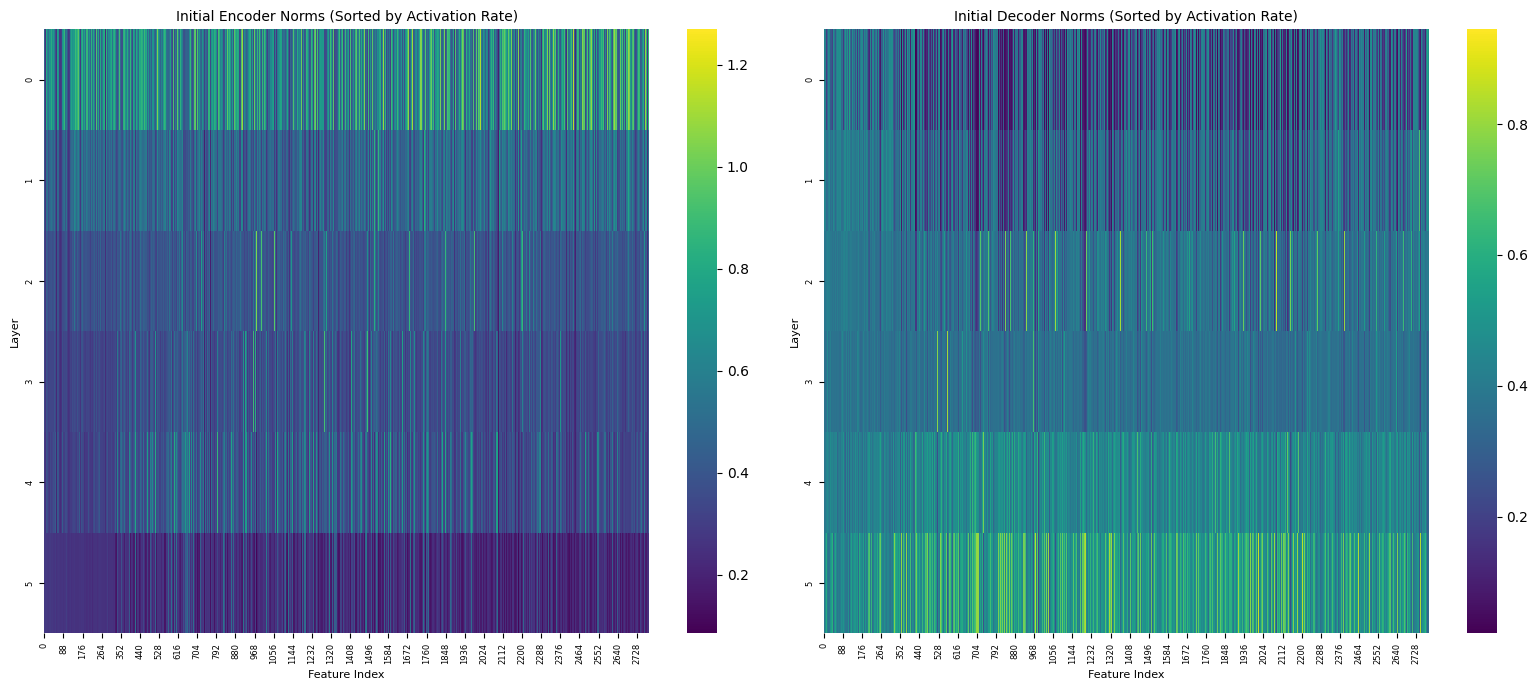

After filtering layer 0 - Active features: 1997


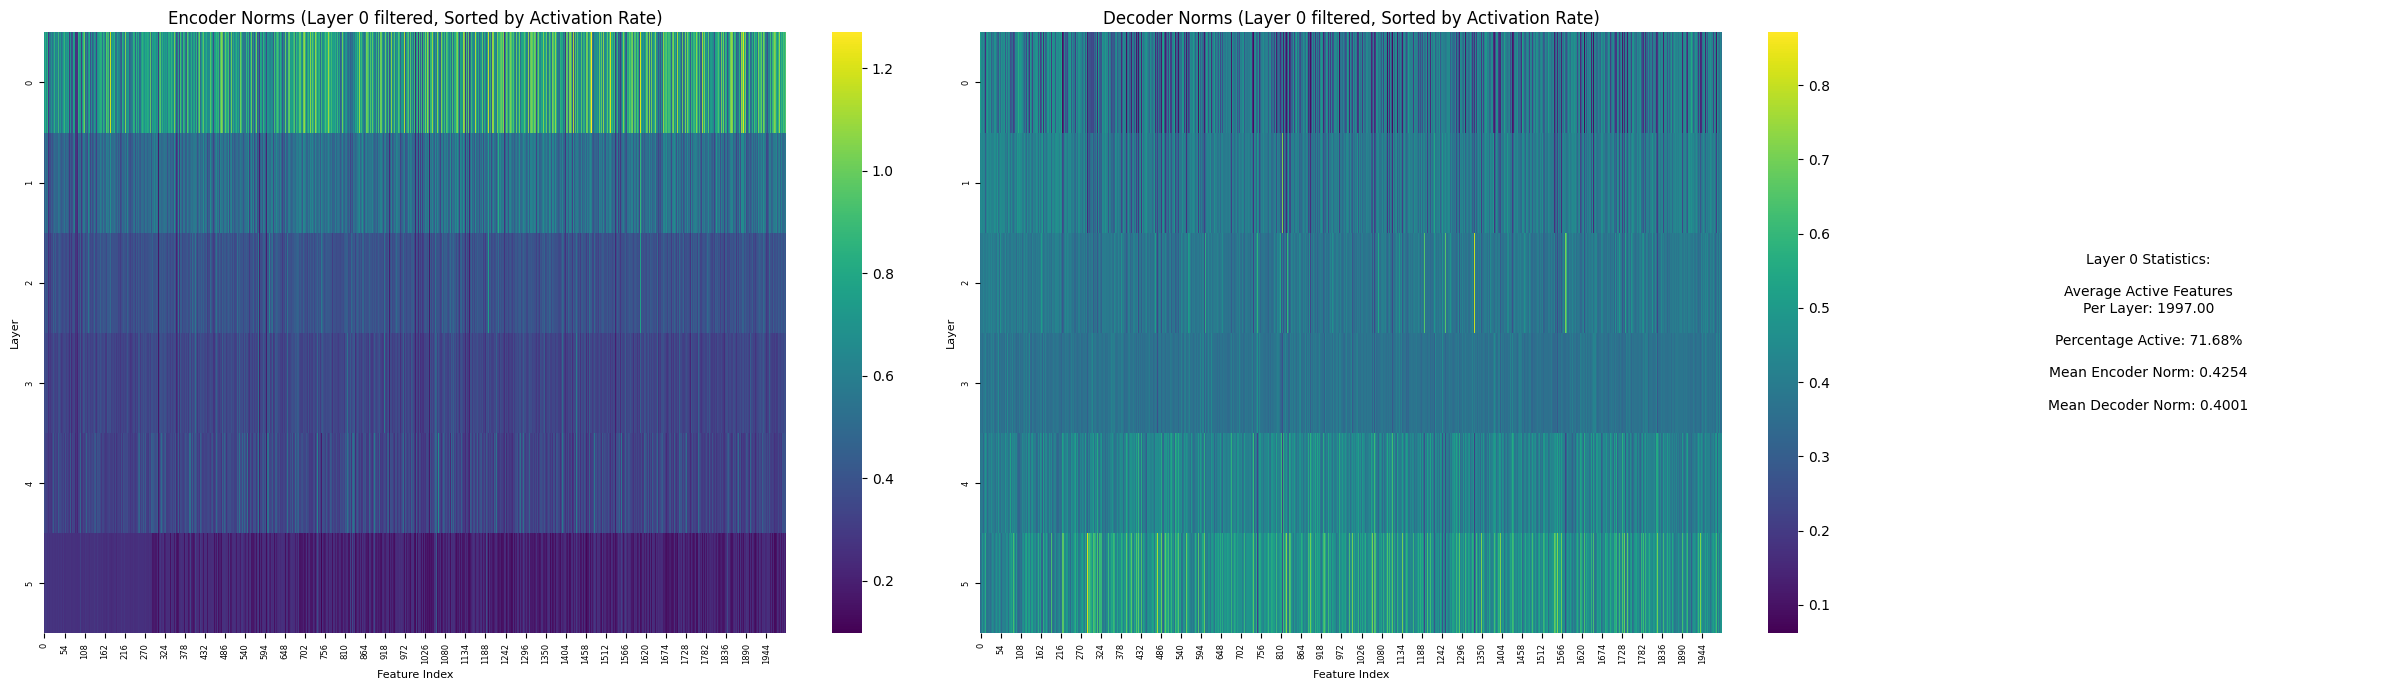

After filtering layer 1 - Active features: 137


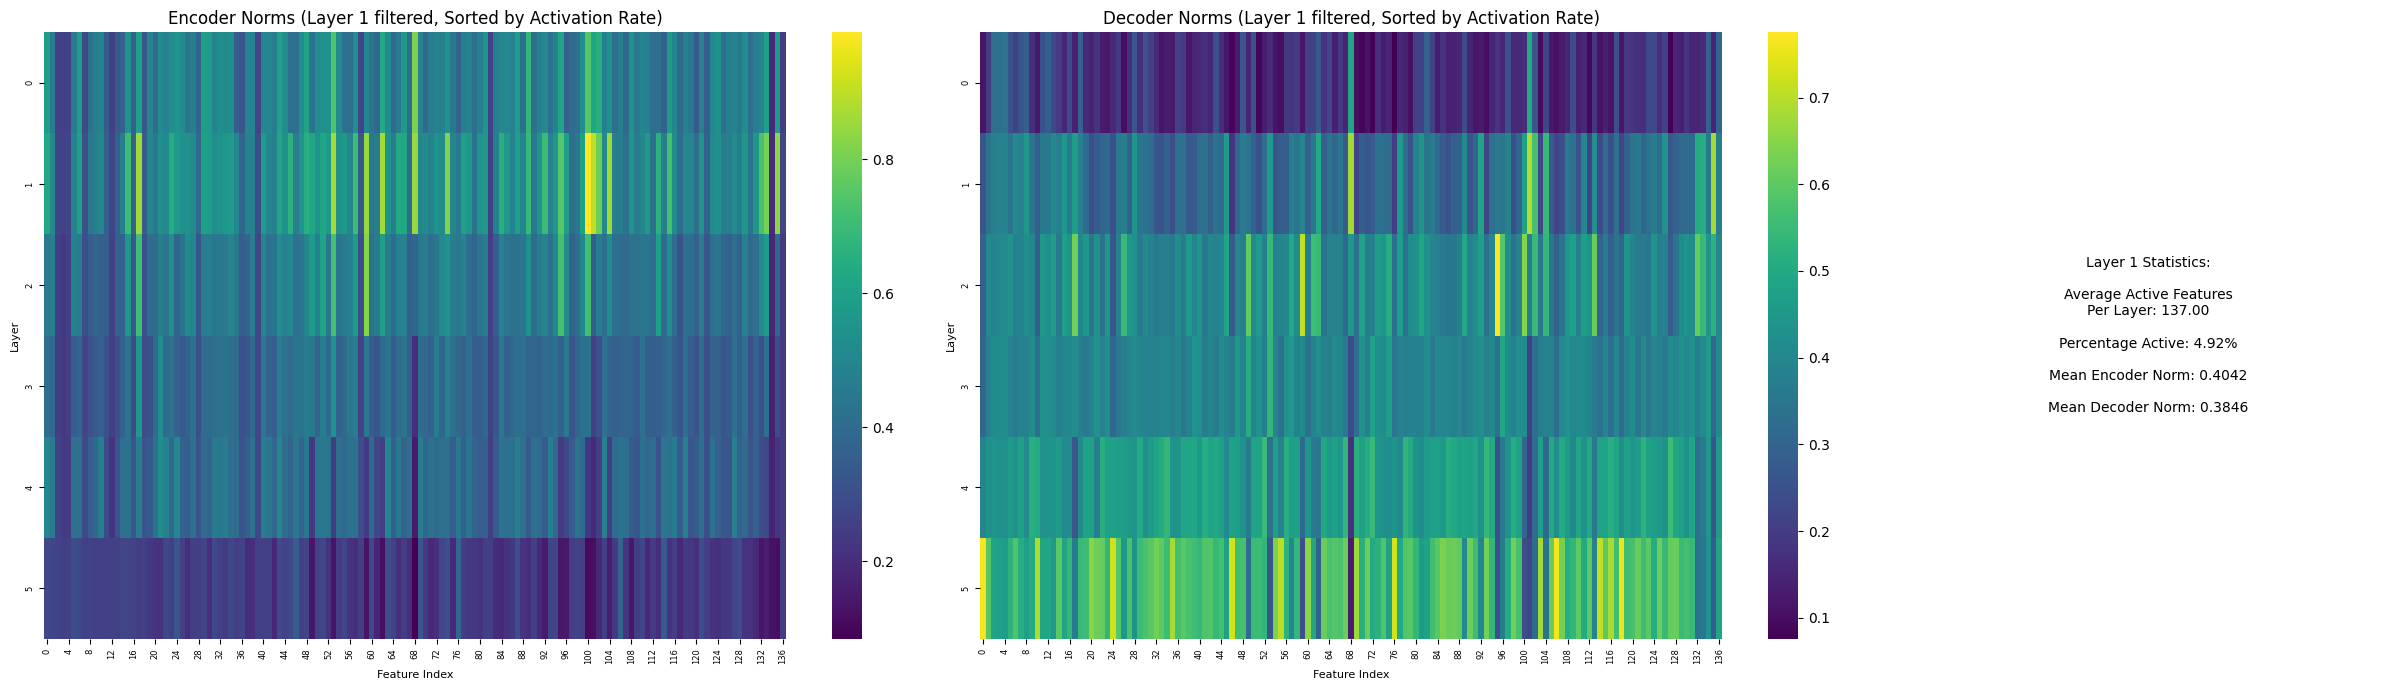

After filtering layer 2 - Active features: 153


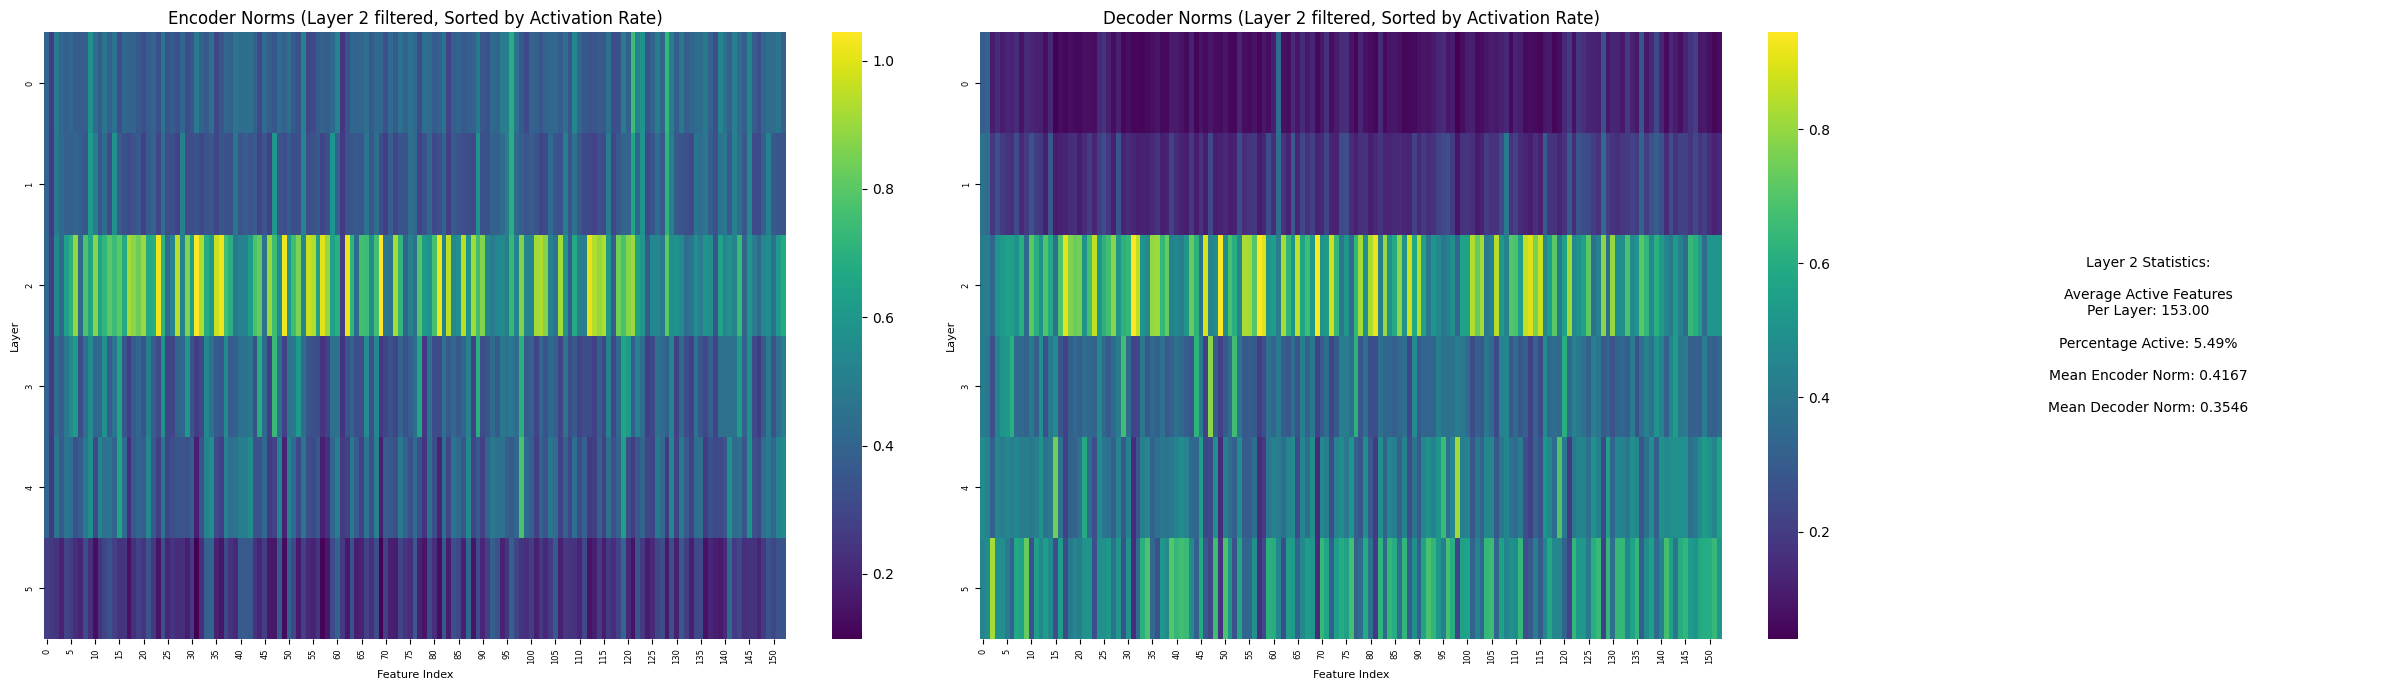

After filtering layer 3 - Active features: 59


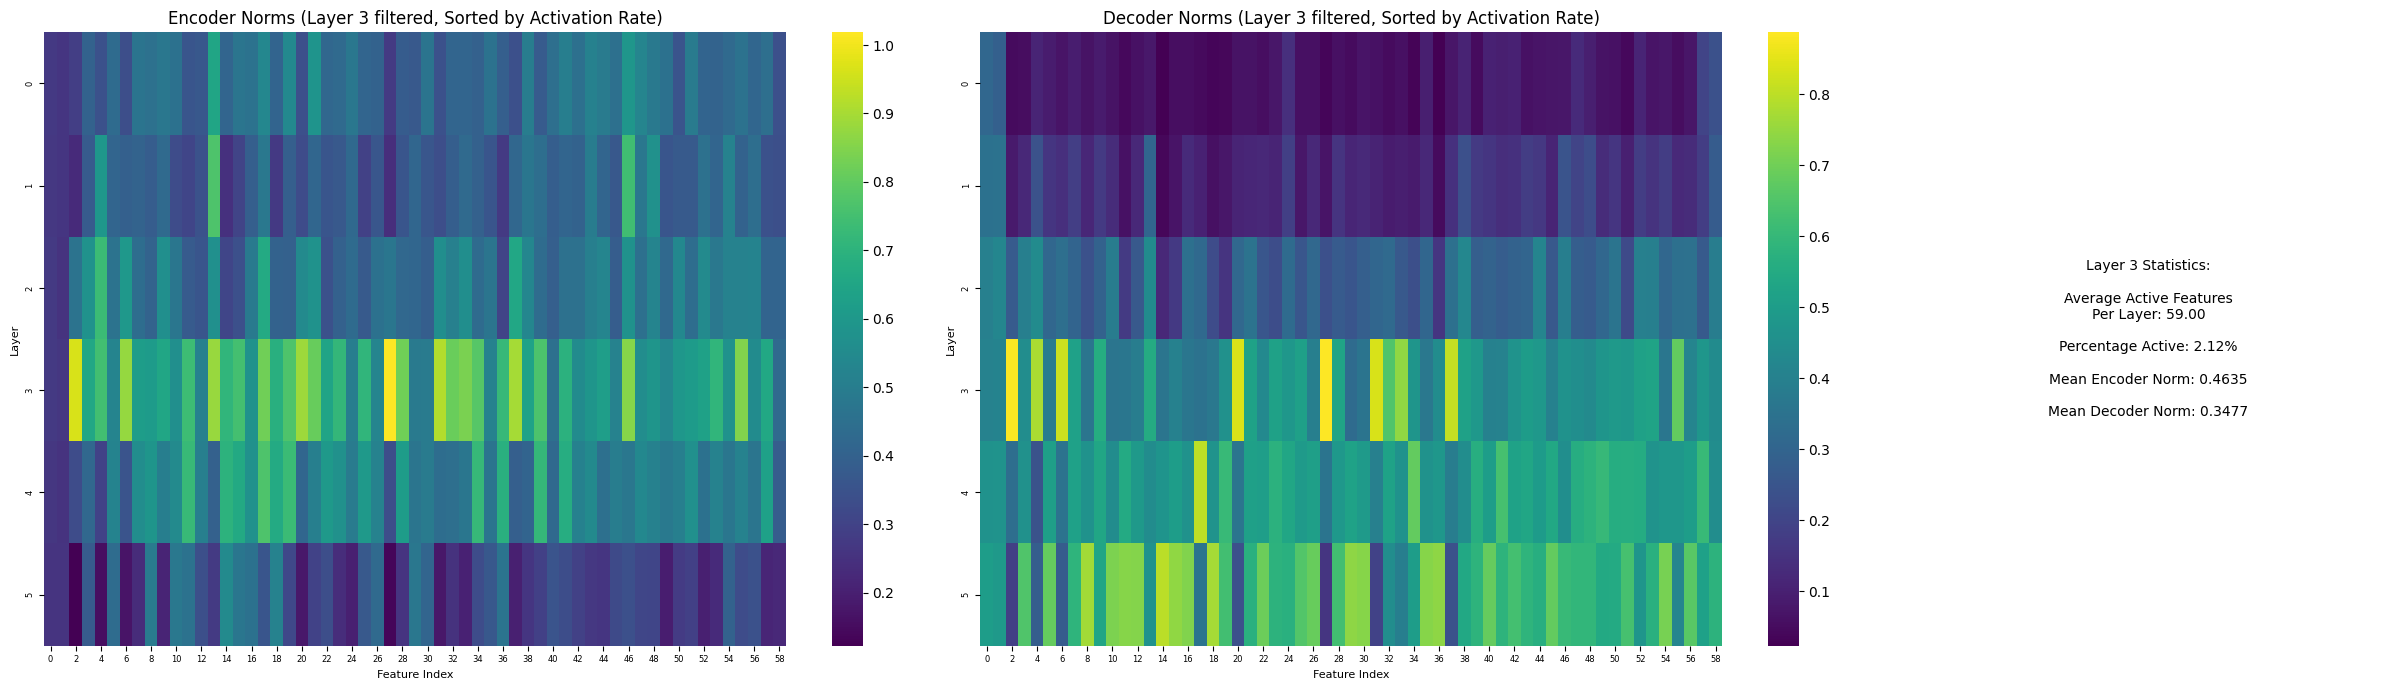

After filtering layer 4 - Active features: 411


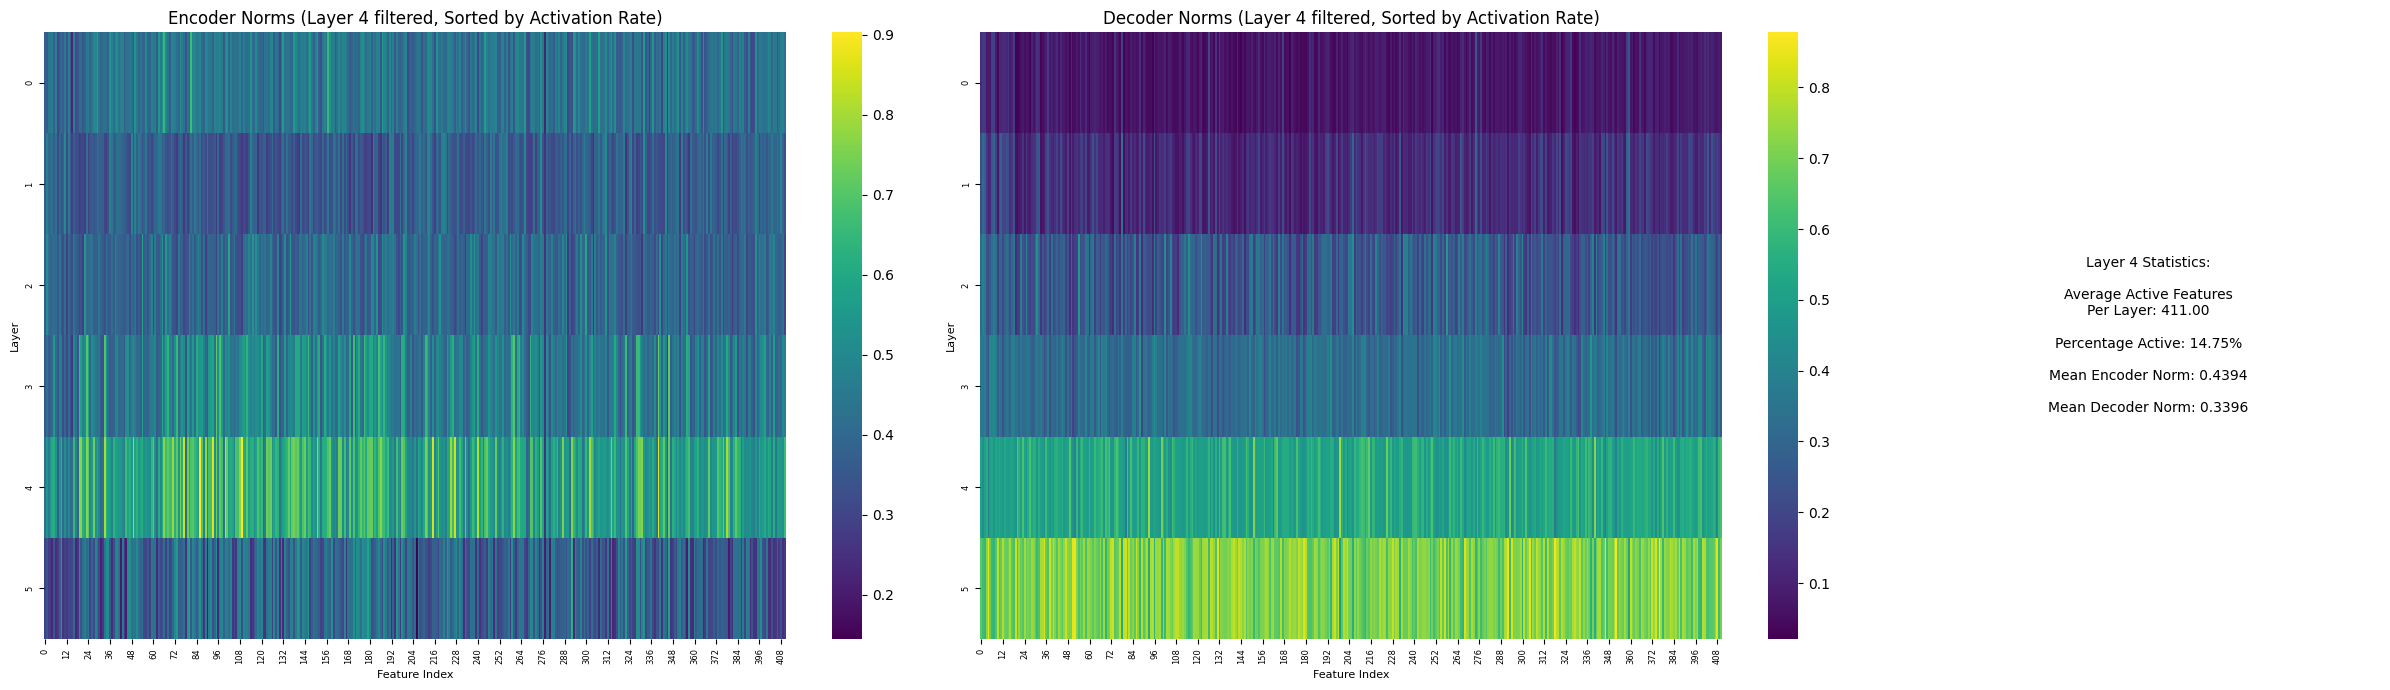

After filtering layer 5 - Active features: 29


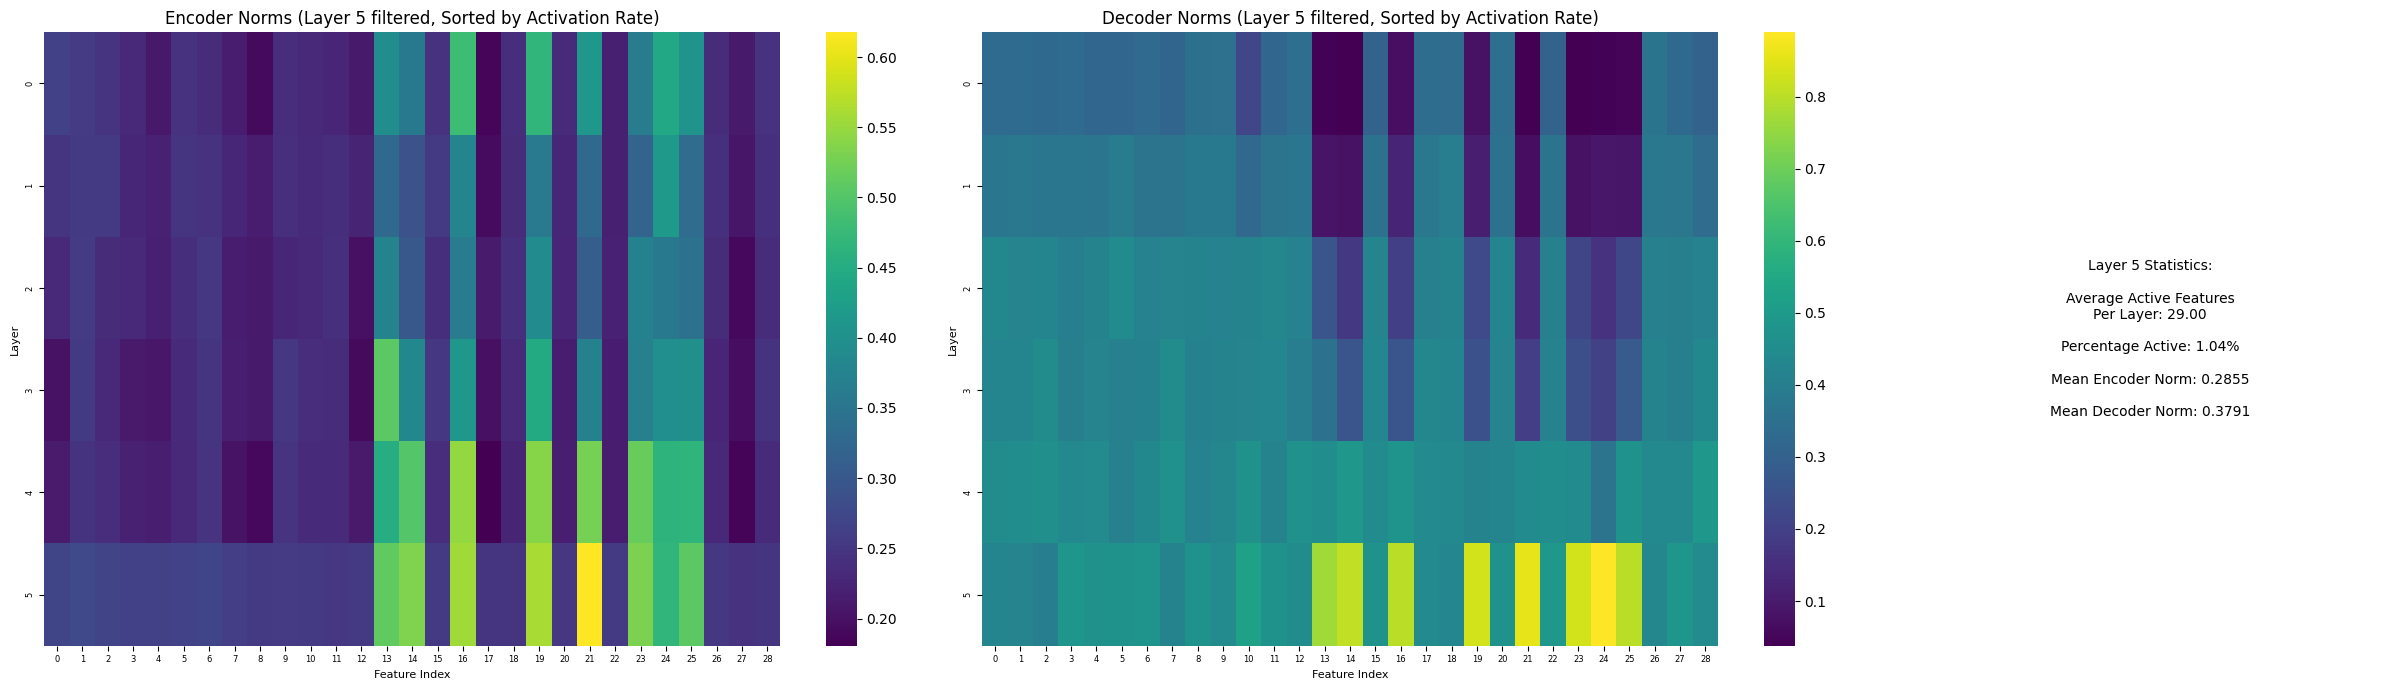

In [24]:
# Usage example:
num_layers = 6
exclude_first_k_tokens = 0
save_folder = (
    f"../assets/{model_name}/layer_filtering_results_exclude_{exclude_first_k_tokens}"
)
activation_threshold = 0.00
norm_threshold = 0.0

filtered_encoder_weights, filtered_encoder_bias, filtered_decoder_weights = (
    filter_inactive_features(
        stats.feature_activation_rate,
        feature_encoder_weights,
        feature_encoder_bias,
        feature_decoder_weights,
        activation_threshold,
    )
)


max_layer_filtering_splits, metadata = process_all_layers(
    filtered_encoder_weights,
    filtered_decoder_weights,
    filtered_encoder_bias,
    num_layers,
    exclude_first_k_tokens,
    save_folder,
)

plot_layerwise_filtering(
    filtered_encoder_weights,
    filtered_decoder_weights,
    num_layers,
    stats.feature_activation_rate,
    save_folder,
    norm_threshold=norm_threshold,
    activation_threshold=activation_threshold,
)

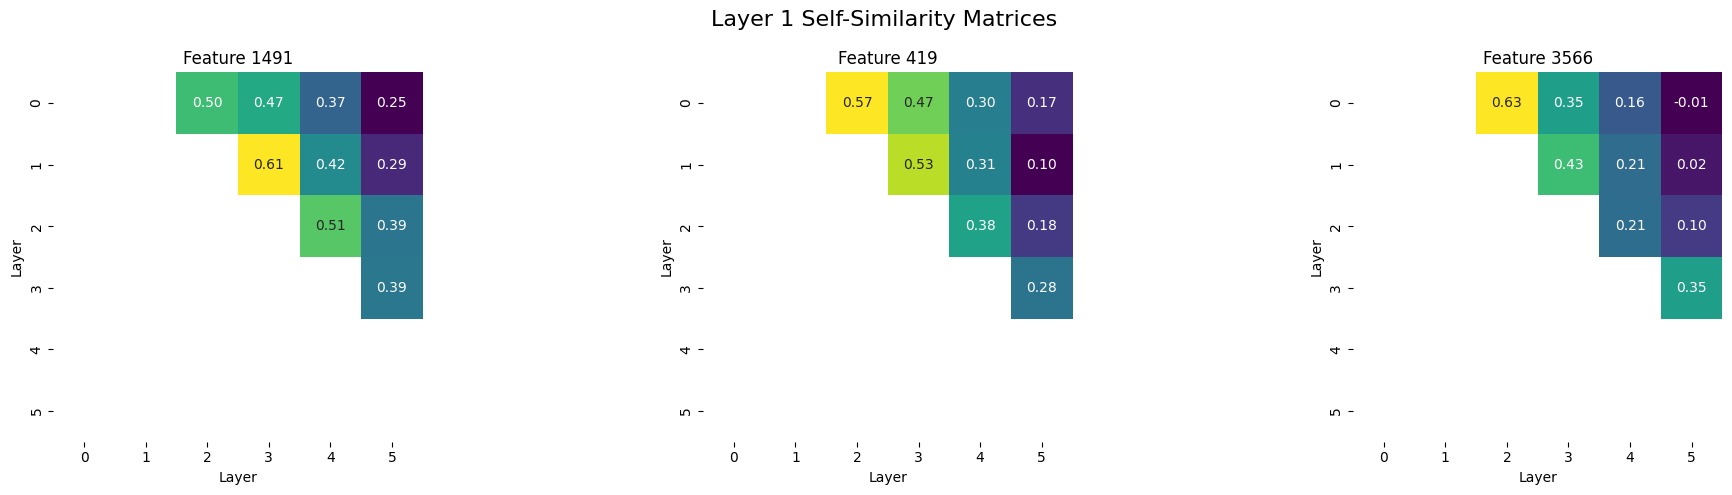

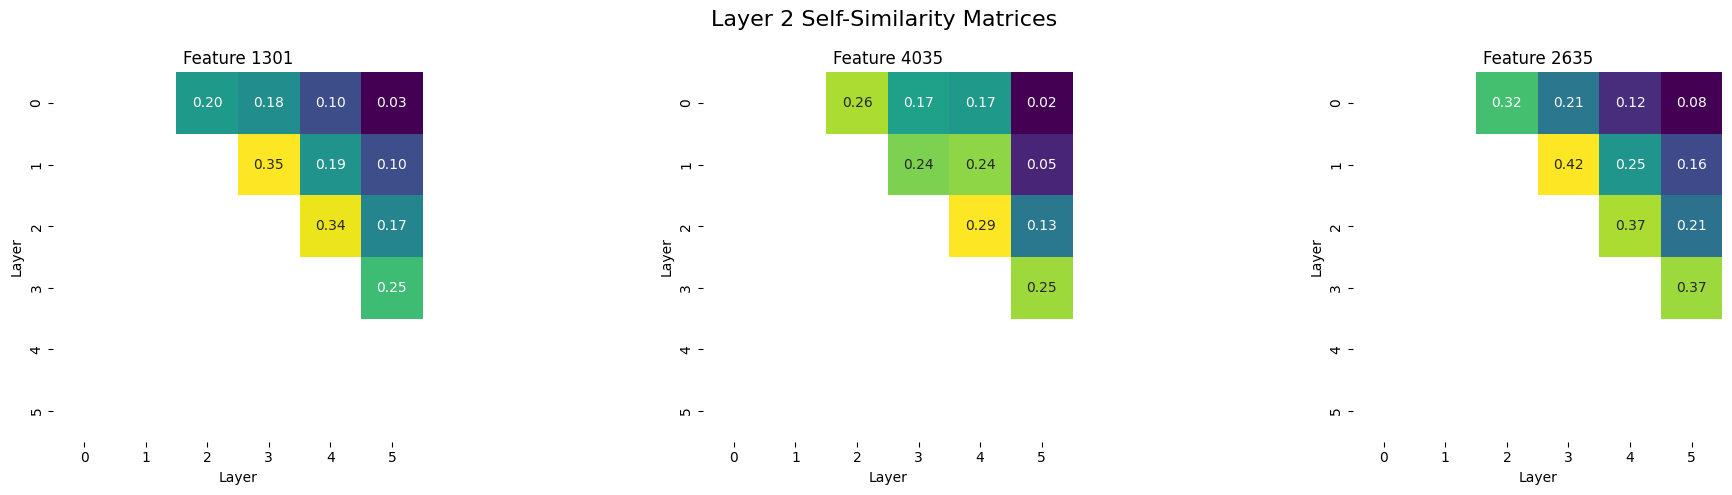

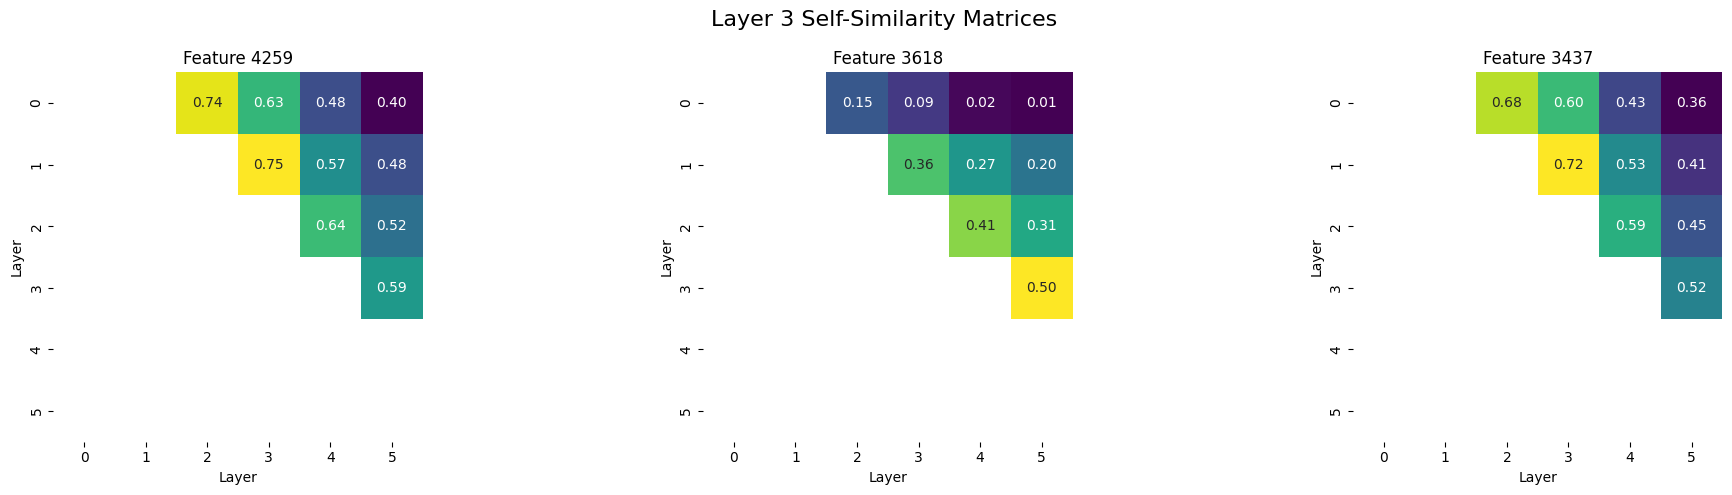

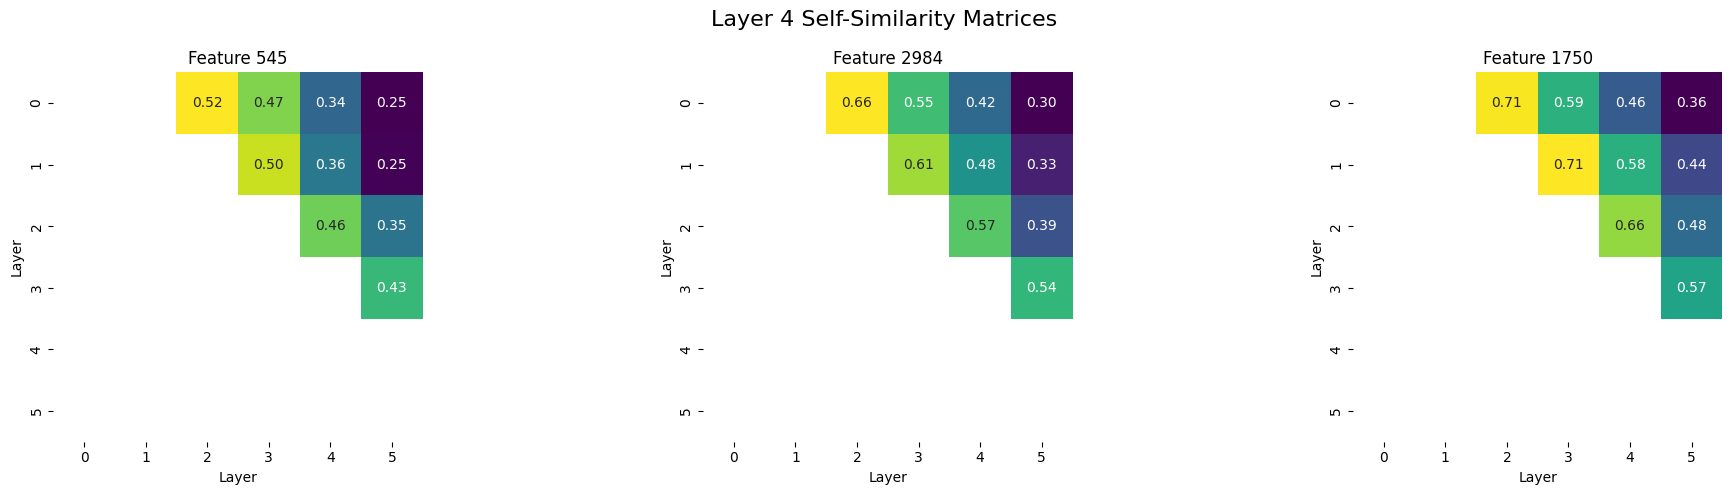

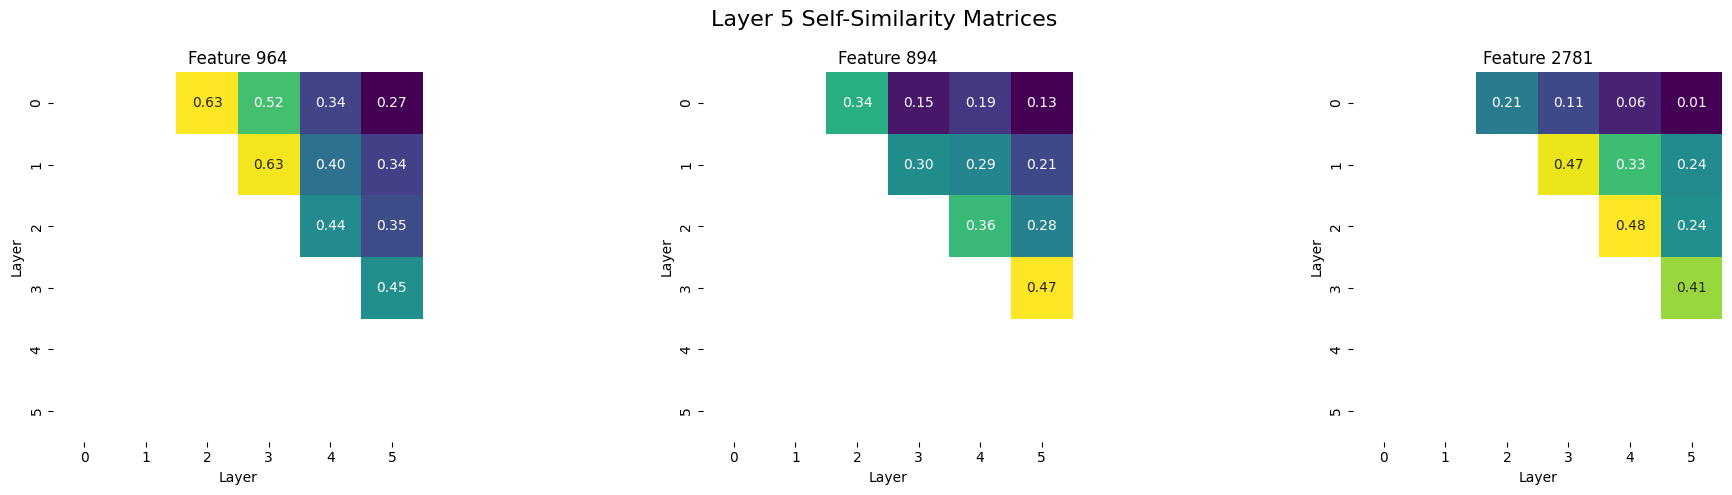

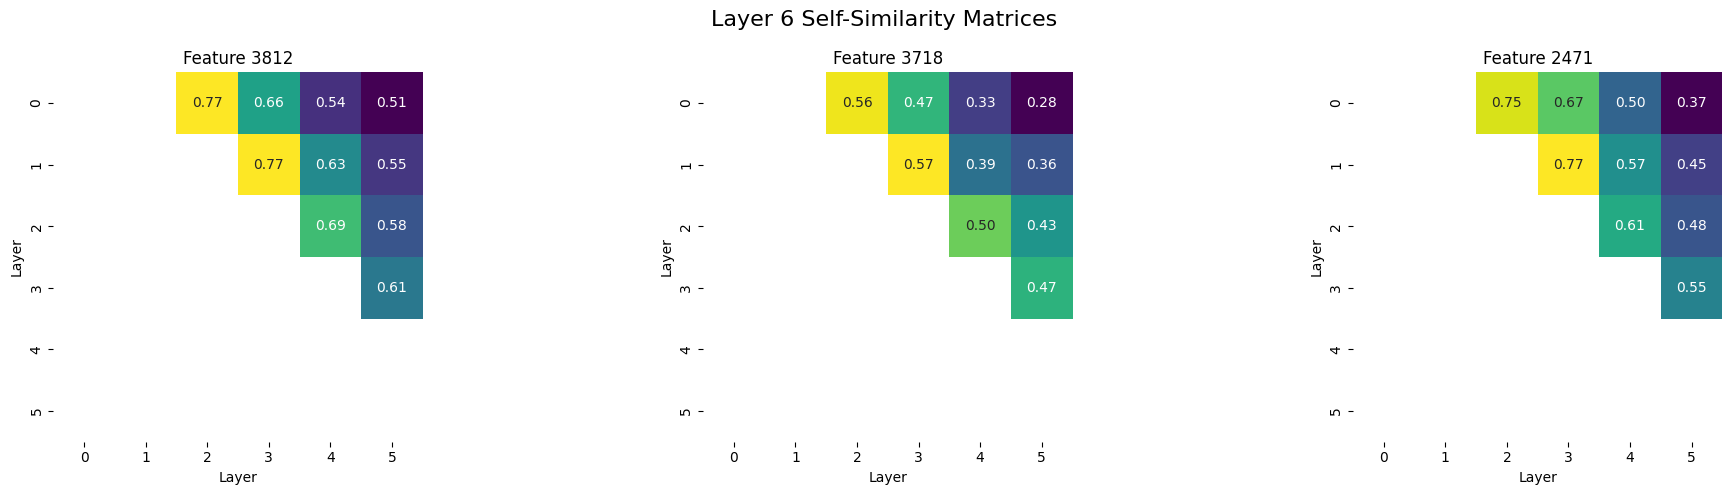

In [ ]:
def plot_multiple_layer_wise_self_similarity(
    decoder_weights, layer_bins, num_layers=6, hidden_size=512, k=4, figsize=(20, 5)
):
    for layer, layer_bin in enumerate(layer_bins):
        # Create a new figure for each layer
        fig, axes = plt.subplots(1, k, figsize=figsize)
        fig.suptitle(f"Layer {layer + 1} Self-Similarity Matrices", fontsize=16)

        # Ensure we only use valid feature indices
        valid_features = [idx for idx in layer_bin if idx < len(decoder_weights)]

        # Adjust k if there aren't enough valid features
        k = min(k, len(valid_features))

        if k == 0:
            print(f"No valid features for layer {layer}. Skipping this layer.")
            plt.close(fig)
            continue

        # Select k random features from the valid features
        feature_indices = random.sample(valid_features, k)

        # Ensure axes is always a list or array
        axes = np.atleast_1d(axes)

        for col, feature_idx in enumerate(feature_indices):
            # Extract the decoder vector for this feature
            feature_vector = decoder_weights[feature_idx]

            # Split the vector into layer-wise chunks
            layer_chunks = torch.stack(torch.split(feature_vector, hidden_size))

            # Compute the similarity matrix using vectorized operations
            similarity_matrix = torch.nn.functional.cosine_similarity(
                layer_chunks.unsqueeze(1), layer_chunks.unsqueeze(0), dim=2
            )

            # Create a mask for the lower triangle
            mask = np.tril(
                np.ones_like(similarity_matrix.cpu().numpy(), dtype=bool), k=1
            )

            # Plot the similarity matrix
            ax = axes[col]
            sns.heatmap(
                similarity_matrix.cpu().numpy(),
                cmap="viridis",
                annot=True,
                fmt=".2f",
                square=True,
                cbar=False,
                mask=mask,
                ax=ax,
            )
            ax.set_title(f"Feature {feature_idx}")
            ax.set_xlabel("Layer")
            ax.set_ylabel("Layer")

        plt.tight_layout()
        plt.show()


# First, let's bin the filtered features
num_layers = 6  # Adjust this based on your model's architecture
filtered_enc_binned_features, filtered_dec_binned_features = bin_features_by_layer(
    feature_encoder_weights, feature_decoder_weights, num_layers
)

filtered_encoder_weights, filtered_encoder_bias, filtered_decoder_weights = (
    filter_inactive_features(
        stats.feature_activation_rate,
        feature_encoder_weights,
        feature_encoder_bias,
        feature_decoder_weights,
        0.0,
    )
)

# Now we can use these binned features in our plotting function
plot_multiple_layer_wise_self_similarity(
    filtered_decoder_weights,
    filtered_enc_binned_features,  # Use encoder binned features
    num_layers=6,
    hidden_size=512,
    k=3,
)

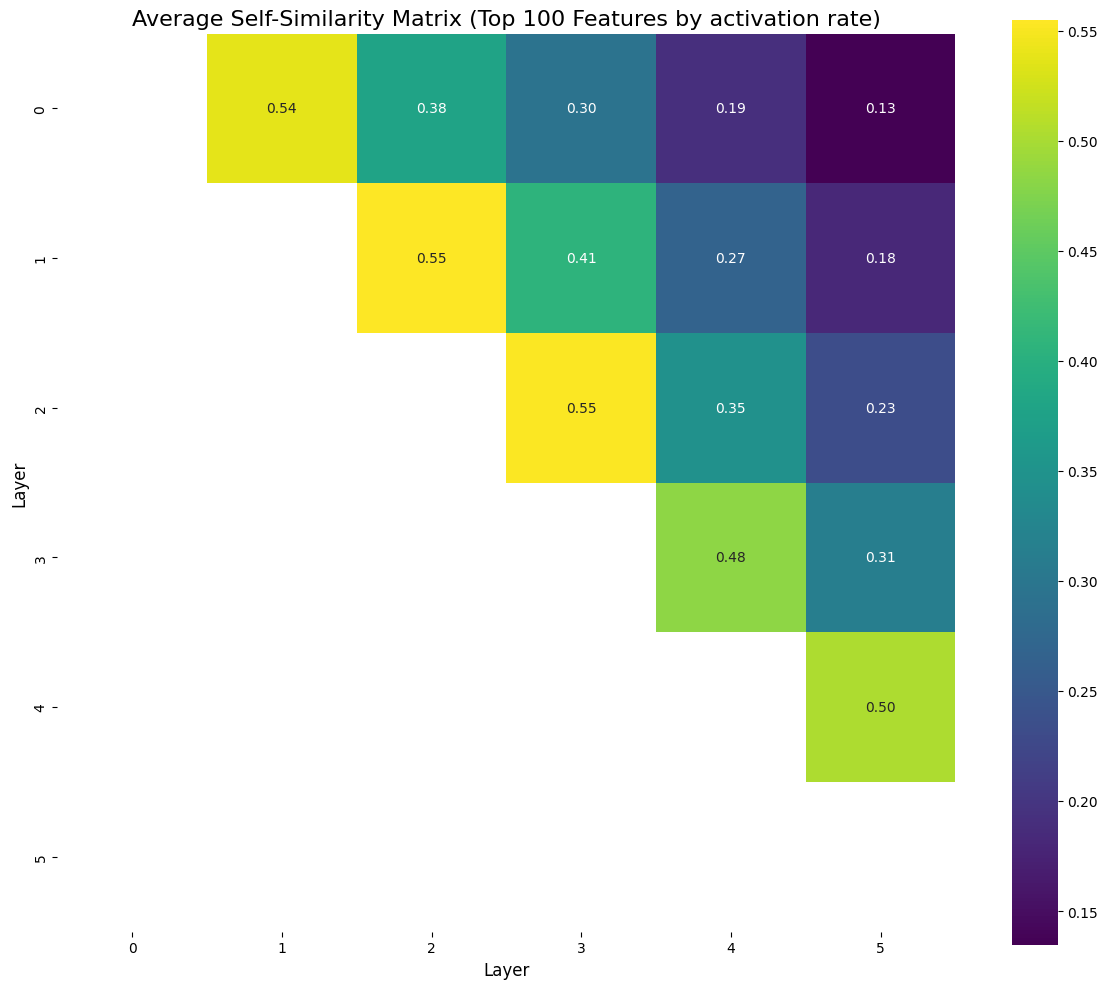

In [ ]:
def plot_global_top_k_self_similarity(
    decoder_weights, activation_rates, num_layers=6, hidden_size=512, k=10, figsize=(12, 10)
):
    # Sort features by activation rate (descending) and select top k
    sorted_indices = torch.argsort(activation_rates, descending=True)
    top_k_indices = sorted_indices[:k]

    # Initialize a tensor to store all similarity matrices
    all_similarities = torch.zeros(k, num_layers, num_layers)

    for i, feature_idx in enumerate(top_k_indices):
        feature_vector = decoder_weights[feature_idx]
        layer_chunks = torch.stack(torch.split(feature_vector, hidden_size))
        similarity_matrix = F.cosine_similarity(
            layer_chunks.unsqueeze(1), layer_chunks.unsqueeze(0), dim=2
        )
        all_similarities[i] = similarity_matrix

    # Compute average similarity matrix
    avg_similarity = torch.mean(all_similarities, dim=0)

    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create mask to exclude diagonal and lower triangle
    mask = np.triu(np.ones_like(avg_similarity.cpu().numpy(), dtype=bool), k=1)
    mask = ~mask  # Invert the mask to keep upper triangle and exclude diagonal

    sns.heatmap(
        avg_similarity.cpu().numpy(),
        cmap="viridis",
        annot=True,
        fmt=".2f",
        square=True,
        mask=mask,
        ax=ax,
    )
    
    ax.set_title(f"Average Self-Similarity Matrix (Top {k} Features by activation rate)", fontsize=16)
    ax.set_xlabel("Layer", fontsize=12)
    ax.set_ylabel("Layer", fontsize=12)

    plt.tight_layout()
    plt.show()

# Assuming stats.feature_activation_rate exists from previous computations
activation_rates = stats.feature_activation_rate

# Filter out features with zero activation rate
nonzero_mask = activation_rates > 0
filtered_activation_rates = activation_rates[nonzero_mask]
filtered_decoder_weights = feature_decoder_weights[nonzero_mask]

# Plot the global top-k self-similarity
plot_global_top_k_self_similarity(
    filtered_decoder_weights,
    filtered_activation_rates,
    num_layers=6,
    hidden_size=512,
    k=100,
)

In [ ]:
# @torch.no_grad()
# def compute_per_token_causal_attribution_strength(
#     j: int,
#     k: int,
#     model: torch.nn.Module,
#     inputs: Dict[str, torch.Tensor],
#     feature_encoder_weights: torch.Tensor,
#     feature_encoder_bias: torch.Tensor,
#     feature_decoder_weights: torch.Tensor,
#     global_feature_activation_rate: torch.Tensor,
#     global_acc_feature_activations: torch.Tensor,
#     lambda_value: float = 1.0,
#     rank_k_feature: int = 1,
#     exclude_first_k_tokens: int = 0,
#     sae_top_k: int = 128,
# ):
#     intervention = perform_intervention(
#         model=model,
#         batch=inputs,
#         global_feature_activation_rate=global_feature_activation_rate,
#         global_acc_feature_activations=global_acc_feature_activations,
#         intervention_index=j,
#         readout_index=k,
#         feature_encoder_weights=feature_encoder_weights,
#         feature_encoder_bias=feature_encoder_bias,
#         feature_decoder_weights=feature_decoder_weights,
#         lambda_value=lambda_value,
#         num_tokens=inputs["input_ids"].shape[1] - exclude_first_k_tokens,
#         feature_top_k=rank_k_feature,
#         exclude_first_k_tokens=exclude_first_k_tokens,
#         sae_top_k=sae_top_k,
#     )

#     # Compute JVP
#     jvp = compute_jvp(
#         model,
#         intervention.clean_base_outputs,
#         intervention.activation_positions,
#         j,
#         k,
#         intervention.v_j.squeeze(),
#         sum_over_tokens=False,
#     )

#     # Initialize lists to store results for each valid token
#     proportion_explained_list = []
#     causal_cosine_list = []
#     error_list = []
#     relative_error_list = []

#     v_k_norm_squared = torch.norm(intervention.v_k, p=2, dim=-1).pow(2)
#     valid_tokens = intervention.is_valid.squeeze()

#     for idx, is_valid in enumerate(valid_tokens.tolist()):
#         if is_valid:
#             # Extract the JVP for this token
#             token_jvp = jvp[idx]

#             # Compute metrics for this token
#             proportion_explained = (
#                 torch.dot(token_jvp, intervention.v_k.squeeze()) / v_k_norm_squared
#             )

#             causal_cosine = F.cosine_similarity(
#                 token_jvp.unsqueeze(0), intervention.v_k, dim=-1
#             )

#             error = torch.mean((token_jvp - intervention.v_k.squeeze()) ** 2)
#             relative_error = error / v_k_norm_squared

#             # Append results
#             proportion_explained_list.append(proportion_explained.item())
#             causal_cosine_list.append(causal_cosine.item())
#             error_list.append(error.item())
#             relative_error_list.append(relative_error.item())
#         else:
#             proportion_explained_list.append(float("nan"))
#             causal_cosine_list.append(float("nan"))
#             error_list.append(float("nan"))
#             relative_error_list.append(float("nan"))

#     return {
#         "proportion_explained": torch.tensor(proportion_explained_list),
#         "causal_cosine": torch.tensor(causal_cosine_list),
#         "error": torch.tensor(error_list),
#         "relative_error": torch.tensor(relative_error_list),
#         "is_valid": intervention.is_valid.squeeze(),
#     }